### Projeto 5 - Recurrent Neural Network (RNN)

## Introdução

### Exemplo 01 - Aplicação de RNN para predição de série temporal

Neste exemplo, será utilizado das redes neurais recorrentes para predição de váriaveis climáticas de uma cidade da Dinamarca baseado nos valores de estações meteorológicas de cidades vizinhas.

#### Dataset
Os dados das estações meteorológicas das cidades de Aalborg, Aarhus, Esbjerg, Odense, Roskilde na Dinamarca para o periodo de 1980-2018.

#### TensorFlow e Keras 
- TensorFlow: É uma biblioteca de código aberto para aprendizado de MachineLearning (Aprendizado de máquina), para este exemplo iremos utilizar a biblioteca tensorflow para linguagem Python
- Keras: O Keras é uma biblioteca especifica para redes neurais feita em Python, tal biblioteca é rodada sobre o TensorFlow e projetada para experimentação rápida de redes neurais profundas.

### Fluxograma

Para esta aplicação, os valores de Temperatura, Pressão Atmosférica e Velocidade do Vento (Temp, Pressure, WindSpeed) da cidade de 'Odense' tentaram ser previstos para as próximas 24 horas a partir dos dados anteriores de 5 outras cidades.

As Redes Neurais Recorrentes (RNN) foram utilizadas devido sua capacidade de trabalhar com sequências de dados com comprimento arbitrário.
Durante o periodo de treinamento da rede, serão utilizados uma sub-sequência de 1344 pontos de dados (8 semanas) do conjunto de treinamento, onde cada ponto de observações possui 20 sinais de entrada para as variáveis climáticas citadas anteriormente.
Após o treinamento da rede neural, o objetivo será produzir sinal das três variáveis (Temp, Pressure, WindSpeed) para o próximo dia, no fluxograma a baixo podemos ver como a rede está descrita a partir da entrada de sinais até a saída passando pela RNN.

<img src="imgs/rnn_01.png" align="center" alt="Drawing" style="width: 600px;">
Fonte: https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/23_Time-Series-Prediction.ipynb

### Bibliotecas

In [1]:
%matplotlib inline
import warnings
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')

Bibliotecas do Keras

In [2]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

Versões utilizadas

In [3]:
print('Versão do TensorFlow: ',tf.__version__)
print('Versão do Keras: ',tf.keras.__version__)
print('Versão do Pandas: ',pd.__version__)

Versão do TensorFlow:  1.15.0
Versão do Keras:  2.2.4-tf
Versão do Pandas:  0.25.2


## Carregando dados

Para baixar os dados das 5 cidades será necessário que os arquivos 'weather.py' e 'download.py' estejam no mesmo diretório deste documento. Os dados meteorológicos das estações foram obtidos a partir do National Climatic Data Center (NCDC), USA. Os arquivos brutos foram extraidos e armazenados no diretório '/dataset'.

In [4]:
import weather
# Função para download e extração automática dos dados
weather.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


In [5]:
# Lista das cidades
cities = weather.cities
cities

['Aalborg', 'Aarhus', 'Esbjerg', 'Odense', 'Roskilde']

Após baixar e setar a lista de cidades será necessário carregar os valores para um DataFrame. Os dados serão carregados e organizados para intervalos de 60 minutos.

In [6]:
df = weather.load_resampled_data()
df.head()

Aalborg                                    Aarhus  \
                         Temp     Pressure WindSpeed     WindDir   Temp   
DateTime                                                                  
1980-03-01 11:00:00  5.000000  1007.766667      10.2  280.000000    5.0   
1980-03-01 12:00:00  5.000000  1008.000000      10.3  290.000000    5.0   
1980-03-01 13:00:00  5.000000  1008.066667       9.7  290.000000    5.0   
1980-03-01 14:00:00  4.333333  1008.133333      11.1  283.333333    5.0   
1980-03-01 15:00:00  4.000000  1008.200000      11.3  280.000000    5.0   

                                                     Esbjerg           \
                        Pressure WindSpeed WindDir      Temp Pressure   
DateTime                                                                
1980-03-01 11:00:00  1008.300000      15.4   290.0  6.083333      NaN   
1980-03-01 12:00:00  1008.600000      13.4   280.0  6.583333      NaN   
1980-03-01 13:00:00  1008.433333      15.4   280.0  6.888889      NaN   
1980-03-01 14:00:00  1008.266667      14.9   300.0  6.222222      NaN   
1980-03-01 15:00:00  1008.100000      17.0   290.0  5.555556      NaN   

                                              Odense                          \
                     WindSpeed     WindDir      Temp     Pressure  WindSpeed   
DateTime                                                                       
1980-03-01 11:00:00  12.383333  310.000000  6.142857  1011.066667  12.585714   
1980-03-01 12:00:00  12.883333  310.000000  7.000000  1011.200000  11.300000   
1980-03-01 13:00:00  13.244444  309.444444  7.000000  1011.300000  12.118182   
1980-03-01 14:00:00  12.911111  306.111111  6.857143  1011.400000  12.742857   
1980-03-01 15:00:00  12.577778  302.777778  6.000000  1011.500000  12.400000   

                             Roskilde                                  
                    WindDir      Temp Pressure  WindSpeed     WindDir  
DateTime                                                               
1980-03-01 11:00:00   290.0  5.000000      NaN  11.466667  280.000000  
1980-03-01 12:00:00   290.0  5.000000      NaN  12.466667  280.000000  
1980-03-01 13:00:00   290.0  5.166667      NaN  13.133333  278.333333  
1980-03-01 14:00:00   290.0  5.833333      NaN  12.300000  270.000000  
1980-03-01 15:00:00   290.0  4.833333      NaN  12.300000  270.000000

Em alguns casos existem dados que não foram registrados e por isso interpolados linearmente para completar a série
No caso das cidades de Esbjerg e Roskilde existem dados de pressão atmosférica que não foram registrados e podem ser vistos nos gráficos a baixo. 

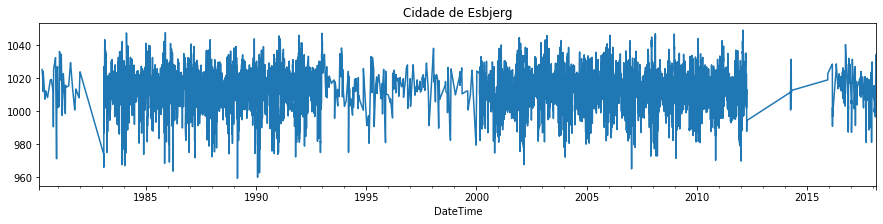

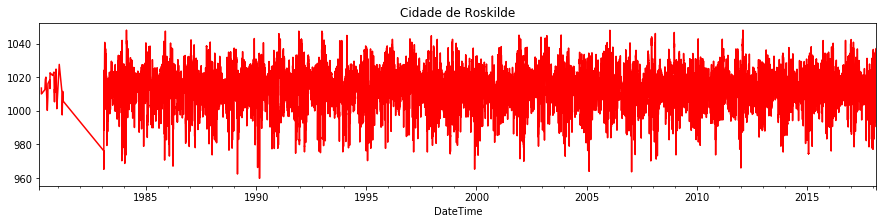

In [7]:
df['Esbjerg']['Pressure'].plot(title='Cidade de Esbjerg', figsize=(15,3))
plt.show()
df['Roskilde']['Pressure'].plot(title='Cidade de Roskilde', figsize=(15,3), color='r')
plt.show()

Devido a utilização de dados de reamostra, foram preenchidos os valores exclusos com valores interpolados linearmente a partir dos vizinhos, porém isso pode confundir a rede neural, por tanto, estas informações devem ser removidas do DataFrame.
Devido a falta de períodos curtos é possivel gerar esses dados a partir de um modelo preditivo que gera os dados ausentes.

In [8]:
print('Quantidade de registros: ', df.values.shape[0], ', Quantidade de entradas: ',df.values.shape[1])
#Função para remoção de valores da coluna 'Pressure' para as cidades Esbjerg e Rosklide
df.drop(('Esbjerg', 'Pressure'), axis=1, inplace=True)
df.drop(('Roskilde', 'Pressure'), axis=1, inplace=True)
print('Quantidade de registros : ', df.values.shape[0], ', Quantidade de entradas após remoção: ',df.values.shape[1])

Quantidade de registros:  333109 , Quantidade de entradas:  20
Quantidade de registros :  333109 , Quantidade de entradas após remoção:  18


Primeiras linhas do DataFrame sem a coluna 'Pressure'

In [9]:
df[['Esbjerg','Roskilde']].head()

Esbjerg                         Roskilde             \
                         Temp  WindSpeed     WindDir      Temp  WindSpeed   
DateTime                                                                    
1980-03-01 11:00:00  6.083333  12.383333  310.000000  5.000000  11.466667   
1980-03-01 12:00:00  6.583333  12.883333  310.000000  5.000000  12.466667   
1980-03-01 13:00:00  6.888889  13.244444  309.444444  5.166667  13.133333   
1980-03-01 14:00:00  6.222222  12.911111  306.111111  5.833333  12.300000   
1980-03-01 15:00:00  5.555556  12.577778  302.777778  4.833333  12.300000   

                                 
                        WindDir  
DateTime                         
1980-03-01 11:00:00  280.000000  
1980-03-01 12:00:00  280.000000  
1980-03-01 13:00:00  278.333333  
1980-03-01 14:00:00  270.000000  
1980-03-01 15:00:00  270.000000

### Erros nos Dados
Outro problema nos dados é que em alguns períodos a variação de temperatura exibida possui saltos nos valores de temperatura, como em Odense com saltos de temperatura de até 50 ºC, porém a temperatura máxima na Dinamarca chega apenas a 36.4 ºC e a mínima a -32.2ºC, estes dados necessitam de um tratamento para evitar erros na predição.

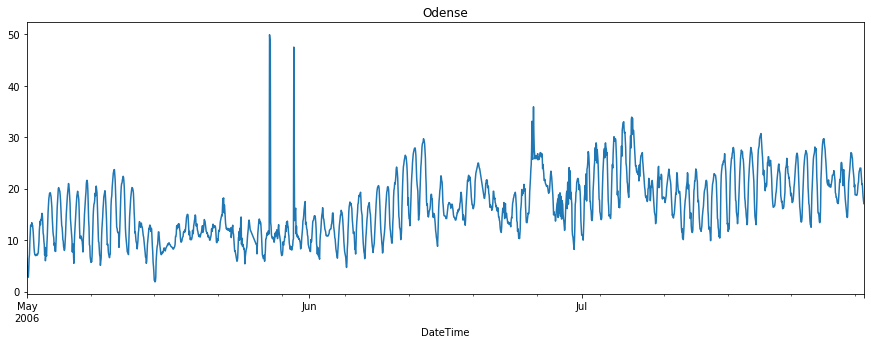

In [10]:
df['Odense']['Temp']['2006-05':'2006-07'].plot(title='Odense',figsize=(15,5))
plt.show()

Essa variação de dados incorreta pode ser confirmada se considerar os dados da cidade de Aarhus, devido a Dinamarca ser um pais com extensões relativamente pequenas é possível considerar os dados de uma estação vizinha.

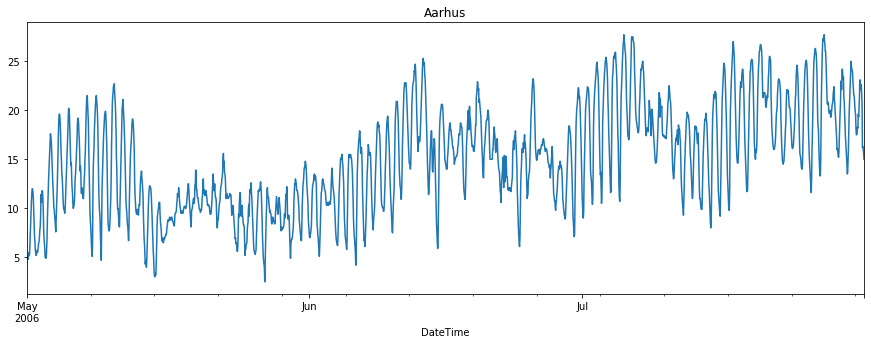

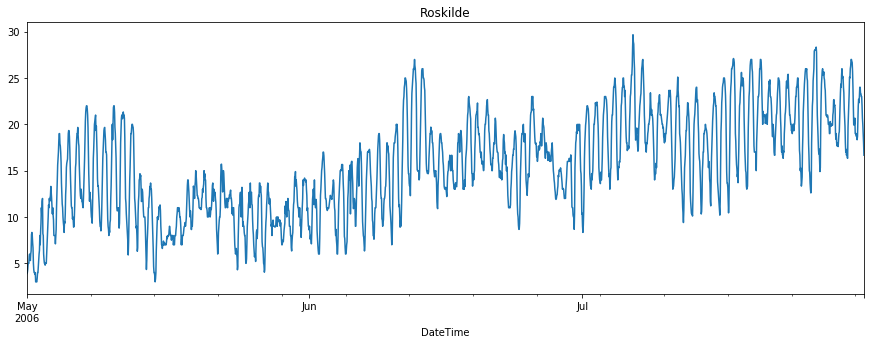

In [11]:
df['Aarhus']['Temp']['2006-05':'2006-07'].plot(title='Aarhus',figsize=(15,5))
plt.show()
df['Roskilde']['Temp']['2006-05':'2006-07'].plot(title='Roskilde',figsize=(15,5))
plt.show()

## Adicionando dados

É possível adicionar alguns sinais de entrada para os dados, e isso ajuda a melhorar o modelo de previsões, por exemplo, dada uma temperatura de 10ºC, o modelo não consegue distinguir se está temperatura seria medida durante o periodo do dia ou da noite, verão ou inverno, o modelo teria que inferir isso a partir dos pontos de dados circundantes, que podem não ter uma precisão alta para determinar se o período é de um inverno anormal quente por exemplo, ou se é no periodo da noite ou do dia, por tanto, essas informações podem influênciar diretamente na precisão do modelo e na sua saída.


Embora o conjunto de dados contenha as informações de data e hora de cada observação, ele é usado apenas no índice para ordenar os dados, portanto, adicionaremos sinais de entrada separados ao conjunto de dados para o dia do ano (entre 1 e 366) e a hora do dia (entre 0 e 23).

In [12]:
df['Various', 'Day'] = df.index.dayofyear
df['Various', 'Hour'] = df.index.hour
df.Various.head()

,Day,Hour
DateTime,,
1980-03-01 11:00:00,61,11
1980-03-01 12:00:00,61,12
1980-03-01 13:00:00,61,13
1980-03-01 14:00:00,61,14
1980-03-01 15:00:00,61,15


### Selecionando a cidade para previsão

A cidade selecionada será a cidade de Odense e as variáveis serão 'Temp, WindSpeed, Pressure' (Temperatura, Velocidade do Vento e Pressão Atmosférica) e a previsão busca fazer previsões para as próximas 24 horas.

A seguir, é apresentado o número de etapas de tempo em que alteraremos os dados alvos, nosso conjunto de dados é amostrado novamente para ter uma observação para cada hora; portanto, existem 24 observações por 24 horas.

Se queremos prever o tempo 24 horas no futuro, alteramos os dados em 24 etapas. Se quisermos prever o tempo em 7 dias, mudaremos os dados em 7 * 24 intervalos de tempo.

In [13]:
target_city = 'Odense'
target_names = ['Temp', 'WindSpeed', 'Pressure']
shift_days = 1
shift_steps = shift_days * 24

As primeiras linhas do DataFrame correspondem ao inicio da série temporal, já as ultimas 24 linhas ao período que se busca prever

In [14]:
# Novo DataFrame com os valores dos dados para previsão
df_targets = df[target_city][target_names].shift(-shift_steps)
df_targets

,Temp,WindSpeed,Pressure
DateTime,,,
1980-03-01 11:00:00,2.000000,6.828571,1005.833333
1980-03-01 12:00:00,2.000000,8.200000,1005.200000
1980-03-01 13:00:00,0.166667,9.216667,1004.766667
1980-03-01 14:00:00,1.000000,11.885714,1004.333333
1980-03-01 15:00:00,1.000000,12.400000,1003.900000
...,...,...,...
2018-03-01 19:00:00,NaN,NaN,NaN
2018-03-01 20:00:00,NaN,NaN,NaN
2018-03-01 21:00:00,NaN,NaN,NaN


AVISO! Você deve verificar se mudou os dados na direção certa! Queremos prever o futuro, não o passado!
O quadro de dados deslocado é confuso porque o Pandas mantém os carimbos de data / hora originais, mesmo que tenhamos alterado os dados. Você pode verificar se a mudança de horário está correta comparando os quadros de dados originais e com alteração de horário.

Esta é a primeira shift_steps + 5 linhas do quadro de dados original:

In [15]:
df[target_city][target_names].head(shift_steps + 5)

,Temp,WindSpeed,Pressure
DateTime,,,
1980-03-01 11:00:00,6.142857,12.585714,1011.066667
1980-03-01 12:00:00,7.000000,11.300000,1011.200000
1980-03-01 13:00:00,7.000000,12.118182,1011.300000
1980-03-01 14:00:00,6.857143,12.742857,1011.400000
1980-03-01 15:00:00,6.000000,12.400000,1011.500000
1980-03-01 16:00:00,4.909091,12.618182,1011.688889
1980-03-01 17:00:00,3.953488,12.646512,1011.877778
1980-03-01 18:00:00,3.674419,11.725581,1012.066667
1980-03-01 19:00:00,3.395349,10.804651,1012.255556


A seguir, são apresentadas as 5 primeiras linhas do DataFrame deslocados no tempo. Isso deve ser idêntico às 5 últimas linhas mostradas acima dos dados originais, exceto o carimbo de data / hora.

In [16]:
df_targets.head(5)

,Temp,WindSpeed,Pressure
DateTime,,,
1980-03-01 11:00:00,2.000000,6.828571,1005.833333
1980-03-01 12:00:00,2.000000,8.200000,1005.200000
1980-03-01 13:00:00,0.166667,9.216667,1004.766667
1980-03-01 14:00:00,1.000000,11.885714,1004.333333
1980-03-01 15:00:00,1.000000,12.400000,1003.900000


O DataFrame com deslocamento no tempo tem o mesmo tamanho que o quadro de dados original, mas as últimas 24 observações são NaN (não número) porque os dados foram deslocados para trás.

In [17]:
df_targets.tail()

,Temp,WindSpeed,Pressure
DateTime,,,
2018-03-01 19:00:00,NaN,NaN,NaN
2018-03-01 20:00:00,NaN,NaN,NaN
2018-03-01 21:00:00,NaN,NaN,NaN
2018-03-01 22:00:00,NaN,NaN,NaN
2018-03-01 23:00:00,NaN,NaN,NaN


In [18]:
df[0:-shift_steps].tail()

Aalborg                            Aarhus           \
                       Temp Pressure WindSpeed WindDir   Temp Pressure   
DateTime                                                                 
2018-02-28 19:00:00    -6.6   1037.7       8.2    70.0   -5.1   1035.9   
2018-02-28 20:00:00    -7.1   1037.5       6.7    70.0   -5.4   1035.8   
2018-02-28 21:00:00    -6.5   1037.0       8.8    80.0   -5.3   1035.6   
2018-02-28 22:00:00    -6.0   1036.9       9.3    80.0   -5.4   1035.2   
2018-02-28 23:00:00    -6.9   1036.4       7.7    70.0   -5.5   1034.9   

                                        Esbjerg                      Odense  \
                    WindSpeed WindDir      Temp WindSpeed    WindDir   Temp   
DateTime                                                                      
2018-02-28 19:00:00       8.2    80.0 -6.000000  8.400000  80.000000   -6.3   
2018-02-28 20:00:00       9.3    80.0 -6.000000  9.300000  80.000000   -6.6   
2018-02-28 21:00:00       9.3    80.0 -6.333333  8.766667  76.666667   -6.9   
2018-02-28 22:00:00       8.8    70.0 -6.700000  7.700000  60.000000   -7.0   
2018-02-28 23:00:00       8.8    70.0 -6.700000  7.100000  70.000000   -7.0   

                                               Roskilde                    \
                    Pressure WindSpeed WindDir     Temp WindSpeed WindDir   
DateTime                                                                    
2018-02-28 19:00:00   1032.8       9.3    70.0     -7.1       7.7    70.0   
2018-02-28 20:00:00   1032.6      10.8    60.0     -7.3       6.7    60.0   
2018-02-28 21:00:00   1032.4       9.8    60.0     -7.7       5.7    60.0   
2018-02-28 22:00:00   1032.3       9.3    70.0     -7.8       5.7    60.0   
2018-02-28 23:00:00   1031.9      10.3    60.0     -7.7       4.1    60.0   

                    Various       
                        Day Hour  
DateTime                          
2018-02-28 19:00:00      59   19  
2018-02-28 20:00:00      59   20  
2018-02-28 21:00:00      59   21  
2018-02-28 22:00:00      59   22  
2018-02-28 23:00:00      59   23

In [19]:
df.tail()

Aalborg                            Aarhus           \
                       Temp Pressure WindSpeed WindDir   Temp Pressure   
DateTime                                                                 
2018-03-01 19:00:00    -4.4   1024.2       7.2    70.0   -3.6   1022.7   
2018-03-01 20:00:00    -4.3   1023.7       6.7    70.0   -3.9   1022.2   
2018-03-01 21:00:00    -3.9   1023.1       8.8    80.0   -3.5   1021.7   
2018-03-01 22:00:00    -3.8   1022.9       7.2    70.0   -3.5   1021.2   
2018-03-01 23:00:00    -4.2   1022.5       7.2    70.0   -3.4   1021.0   

                                        Esbjerg                      Odense  \
                    WindSpeed WindDir      Temp WindSpeed    WindDir   Temp   
DateTime                                                                      
2018-03-01 19:00:00       8.8    70.0 -5.000000  6.366667  70.000000   -4.4   
2018-03-01 20:00:00       8.2    60.0 -4.333333  6.866667  80.000000   -5.0   
2018-03-01 21:00:00       8.2    80.0 -5.000000  8.200000  80.000000   -5.2   
2018-03-01 22:00:00       8.2    80.0 -5.000000  6.366667  66.666667   -5.0   
2018-03-01 23:00:00       7.7    80.0 -5.333333  6.533333  60.000000   -4.7   

                                               Roskilde                    \
                    Pressure WindSpeed WindDir     Temp WindSpeed WindDir   
DateTime                                                                    
2018-03-01 19:00:00   1020.4       8.8    60.0     -4.4       6.2    60.0   
2018-03-01 20:00:00   1019.8       8.2    60.0     -4.6       6.2    70.0   
2018-03-01 21:00:00   1019.2       7.7    60.0     -5.1       5.1    60.0   
2018-03-01 22:00:00   1018.7       8.8    60.0     -5.2       5.1    60.0   
2018-03-01 23:00:00   1018.3       9.3    60.0     -5.3       4.1    60.0   

                    Various       
                        Day Hour  
DateTime                          
2018-03-01 19:00:00      60   19  
2018-03-01 20:00:00      60   20  
2018-03-01 21:00:00      60   21  
2018-03-01 22:00:00      60   22  
2018-03-01 23:00:00      60   23

### DataFrame para Vetor

Para entrada da rede é necessário converter o DataFrame (Pandas) para um vetor, isso é feito através da biblioteca NumPy, é necessário remover a ultima parte que contem valores NaN

In [20]:
# Parte final do DataFrame original (01-03-2018)
df.tail()

Aalborg                            Aarhus           \
                       Temp Pressure WindSpeed WindDir   Temp Pressure   
DateTime                                                                 
2018-03-01 19:00:00    -4.4   1024.2       7.2    70.0   -3.6   1022.7   
2018-03-01 20:00:00    -4.3   1023.7       6.7    70.0   -3.9   1022.2   
2018-03-01 21:00:00    -3.9   1023.1       8.8    80.0   -3.5   1021.7   
2018-03-01 22:00:00    -3.8   1022.9       7.2    70.0   -3.5   1021.2   
2018-03-01 23:00:00    -4.2   1022.5       7.2    70.0   -3.4   1021.0   

                                        Esbjerg                      Odense  \
                    WindSpeed WindDir      Temp WindSpeed    WindDir   Temp   
DateTime                                                                      
2018-03-01 19:00:00       8.8    70.0 -5.000000  6.366667  70.000000   -4.4   
2018-03-01 20:00:00       8.2    60.0 -4.333333  6.866667  80.000000   -5.0   
2018-03-01 21:00:00       8.2    80.0 -5.000000  8.200000  80.000000   -5.2   
2018-03-01 22:00:00       8.2    80.0 -5.000000  6.366667  66.666667   -5.0   
2018-03-01 23:00:00       7.7    80.0 -5.333333  6.533333  60.000000   -4.7   

                                               Roskilde                    \
                    Pressure WindSpeed WindDir     Temp WindSpeed WindDir   
DateTime                                                                    
2018-03-01 19:00:00   1020.4       8.8    60.0     -4.4       6.2    60.0   
2018-03-01 20:00:00   1019.8       8.2    60.0     -4.6       6.2    70.0   
2018-03-01 21:00:00   1019.2       7.7    60.0     -5.1       5.1    60.0   
2018-03-01 22:00:00   1018.7       8.8    60.0     -5.2       5.1    60.0   
2018-03-01 23:00:00   1018.3       9.3    60.0     -5.3       4.1    60.0   

                    Various       
                        Day Hour  
DateTime                          
2018-03-01 19:00:00      60   19  
2018-03-01 20:00:00      60   20  
2018-03-01 21:00:00      60   21  
2018-03-01 22:00:00      60   22  
2018-03-01 23:00:00      60   23

In [21]:
# Parte final do DataFrame original sem o ultimo dia (28-02-2018)
df[0:-shift_steps].tail()

Aalborg                            Aarhus           \
                       Temp Pressure WindSpeed WindDir   Temp Pressure   
DateTime                                                                 
2018-02-28 19:00:00    -6.6   1037.7       8.2    70.0   -5.1   1035.9   
2018-02-28 20:00:00    -7.1   1037.5       6.7    70.0   -5.4   1035.8   
2018-02-28 21:00:00    -6.5   1037.0       8.8    80.0   -5.3   1035.6   
2018-02-28 22:00:00    -6.0   1036.9       9.3    80.0   -5.4   1035.2   
2018-02-28 23:00:00    -6.9   1036.4       7.7    70.0   -5.5   1034.9   

                                        Esbjerg                      Odense  \
                    WindSpeed WindDir      Temp WindSpeed    WindDir   Temp   
DateTime                                                                      
2018-02-28 19:00:00       8.2    80.0 -6.000000  8.400000  80.000000   -6.3   
2018-02-28 20:00:00       9.3    80.0 -6.000000  9.300000  80.000000   -6.6   
2018-02-28 21:00:00       9.3    80.0 -6.333333  8.766667  76.666667   -6.9   
2018-02-28 22:00:00       8.8    70.0 -6.700000  7.700000  60.000000   -7.0   
2018-02-28 23:00:00       8.8    70.0 -6.700000  7.100000  70.000000   -7.0   

                                               Roskilde                    \
                    Pressure WindSpeed WindDir     Temp WindSpeed WindDir   
DateTime                                                                    
2018-02-28 19:00:00   1032.8       9.3    70.0     -7.1       7.7    70.0   
2018-02-28 20:00:00   1032.6      10.8    60.0     -7.3       6.7    60.0   
2018-02-28 21:00:00   1032.4       9.8    60.0     -7.7       5.7    60.0   
2018-02-28 22:00:00   1032.3       9.3    70.0     -7.8       5.7    60.0   
2018-02-28 23:00:00   1031.9      10.3    60.0     -7.7       4.1    60.0   

                    Various       
                        Day Hour  
DateTime                          
2018-02-28 19:00:00      59   19  
2018-02-28 20:00:00      59   20  
2018-02-28 21:00:00      59   21  
2018-02-28 22:00:00      59   22  
2018-02-28 23:00:00      59   23

#### Vetor de Entrada:

In [22]:
# Vetor de ENTRADA com sem as posições do dia 01-03-2018, sem a primeira linha dos indices
x_data = df.values[0:-shift_steps]

print('Tipo dos dados: ',type(x_data))
print("Tamanho de entradas (observações) e número de atributos ", x_data.shape)

Tipo dos dados:  <class 'numpy.ndarray'>
Tamanho de entradas (observações) e número de atributos  (333085, 20)


In [23]:
# Ultimos valores do vetor de saída
x_data[-1]

array([  -6.9, 1036.4,    7.7,   70. ,   -5.5, 1034.9,    8.8,   70. ,
         -6.7,    7.1,   70. ,   -7. , 1031.9,   10.3,   60. ,   -7.7,
          4.1,   60. ,   59. ,   23. ])

In [24]:
# Valores correspondem ao dia 28-03-2018
df.tail(25).head(1)

Aalborg                            Aarhus           \
                       Temp Pressure WindSpeed WindDir   Temp Pressure   
DateTime                                                                 
2018-02-28 23:00:00    -6.9   1036.4       7.7    70.0   -5.5   1034.9   

                                      Esbjerg                   Odense  \
                    WindSpeed WindDir    Temp WindSpeed WindDir   Temp   
DateTime                                                                 
2018-02-28 23:00:00       8.8    70.0    -6.7       7.1    70.0   -7.0   

                                               Roskilde                    \
                    Pressure WindSpeed WindDir     Temp WindSpeed WindDir   
DateTime                                                                    
2018-02-28 23:00:00   1031.9      10.3    60.0     -7.7       4.1    60.0   

                    Various       
                        Day Hour  
DateTime                          
2018-02-28 23:00:00      59   23

#### Vetor de Saída (Target):

In [292]:
df_targets

,TempBS_ORX,TempBU_ORX,UmidR_ORX,Pres_ORX
datetime,,,,
1988-01-01 00:00:00,28.4,25.800000,80.0,1002.6
1988-01-01 12:00:00,26.3,24.800000,88.0,1006.2
1988-01-01 18:00:00,29.7,26.800000,79.0,1002.8
1988-01-02 00:00:00,28.2,26.600000,88.0,1002.6
1988-01-02 12:00:00,26.2,24.600000,88.0,1005.1
...,...,...,...,...
2013-08-12 00:00:00,23.9,24.364357,98.0,1000.0
2014-01-25 18:00:00,24.2,24.688494,92.0,1009.6
2016-05-06 18:00:00,NaN,NaN,NaN,NaN


In [25]:
# Vetor de saída a partir do DataFrame target (Cidade Odense), ultimas linhas para previsão
y_data = df_targets.values[:-shift_steps]
print('Tipo dos dados: ',type(y_data))
print("Tamanho de saída (observações) e número de atributos ", y_data.shape)

Tipo dos dados:  <class 'numpy.ndarray'>
Tamanho de saída (observações) e número de atributos  (333085, 3)


In [26]:
# Ultimos valores do vetor de saída
y_data[-1]

array([  -4.7,    9.3, 1018.3])

In [27]:
# Valores correspondem ao dia 28-03-2018
df_targets.tail(25).head()

,Temp,WindSpeed,Pressure
DateTime,,,
2018-02-28 23:00:00,-4.7,9.3,1018.3
2018-03-01 00:00:00,NaN,NaN,NaN
2018-03-01 01:00:00,NaN,NaN,NaN
2018-03-01 02:00:00,NaN,NaN,NaN
2018-03-01 03:00:00,NaN,NaN,NaN


Observação: O número de elementos para os vetore de entrada e saída devem possuir o mesmo tamanho

In [28]:
print('Tamanho do Vetor de Entrada: ', len(x_data))
print('Tamanho do Vetor de Saída: ', len(y_data))

Tamanho do Vetor de Entrada:  333085
Tamanho do Vetor de Saída:  333085


### Treinamento e Teste

Para este experimento serão selecionados 90% dos dados para treinamento e 10% para teste

In [29]:
# numero de dados de oberservação
num_data = len(x_data)

# fração para treinamento
train_split = 0.9

# número de elementos para treinamento
num_train = int(train_split * num_data)
print('Número de elementos para treinamento: ', num_train)
num_test = num_data - num_train
print('Número de elementos para teste: ', num_test)

Número de elementos para treinamento:  299776
Número de elementos para teste:  33309


##### Vetores de treinamento e teste:

In [30]:
# vetores de entrada para teste e treinamento
x_train = x_data[0:num_train]
x_test = x_data[num_train:]

In [31]:
# vetores de saída para teste e treinamento
y_train = y_data[0:num_train]
y_test = y_data[num_train:]

In [32]:
# numero de atributos de entrada
num_x_signals = x_data.shape[1]
print('Atributos de entrada: ', num_x_signals)
num_y_signals = y_data.shape[1]
print('Atributos de saída: ', num_y_signals)

Atributos de entrada:  20
Atributos de saída:  3


### Normalização dos dados

Os dados de entrada e saída estão em escalas diferentes, variando de valores negativos (ex: temperatura) a valores altos (pressão), por tanto, é necessário aplicar uma normalização dos dados para que esta variação seja de 0 à 1 pois as redes neurais trabalham melhor nesta escala, para isso é possível utilizar a função MinMaxScaler da biblioteca scikit-learn. 

In [33]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: -27.0
Max: 1050.8


In [34]:
# objeto para os sinais de entrada
x_scaler = MinMaxScaler()

In [35]:
# função para normalização dos dados de entrada do treinamento
x_train_scaled = x_scaler.fit_transform(x_train)

In [36]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0000000000000002


In [37]:
# o mesmo objeto x_caler é utilizado para os valores de teste
x_test_scaled = x_scaler.transform(x_test)

In [38]:
# outra funcao para normalização dos dados de treinamento e teste da saída
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [39]:
print("Min:", np.min(y_train_scaled))
print("Max:", np.max(y_train_scaled))

Min: 0.0
Max: 1.0


### Geração de dados em lote

Os dados já estão preparados de forma vetorial e bi-dimensional, porém para o treinamento é possivel melhorar a forma de entrada para rede, organizando os mesmos em lotes, a função a baixo cria o melhor lote para sub-sequência dos dados de forma aleatória.

In [40]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

Quanto maior o tamanho do lote, maior a carga de trabalhos para os processadores, por tanto é necessário que o valor do batch_size seja de acordo com um valor ideial para o processodor e memória.

In [41]:
batch_size = 256

Usaremos um comprimento de sequência de 1344, o que significa que cada sequência aleatória contém observações por 8 semanas. Um intervalo de tempo corresponde a uma hora, portanto, intervalos de tempo 24 x 7 correspondem a uma semana e 24 x 7 x 8 correspondem a 8 semanas.

In [42]:
sequence_length = 24 * 7 * 8

In [43]:
# gerador de dados em lote
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [44]:
# teste para o gerador de dados em lote
x_batch, y_batch = next(generator)

Isso nos fornece um lote aleatório de 256 seqüências, cada uma com 1344 observações e cada observação com 20 sinais de entrada e 3 sinais de saída.

In [45]:
print(x_batch.shape)
print(y_batch.shape)

(256, 1344, 20)
(256, 1344, 3)


Podemos plotar esses dados para verificar como é o comportamento dos sinais e observar sua aleatoriedade

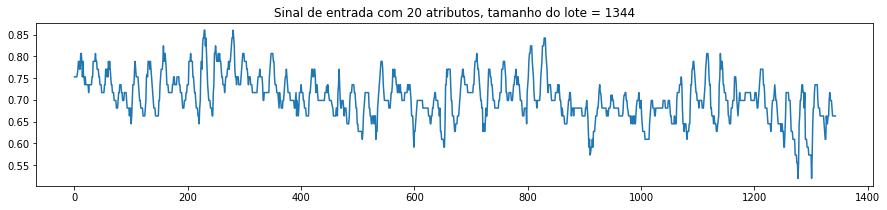

In [46]:
batch = 0   # Primeiro bloco 
signal = 0  # Primeiro sinal a partir dos dados com 20 atributos
seq = x_batch[batch, :, signal]
plt.figure(figsize=(15,3))
plt.title(label='Sinal de entrada com 20 atributos, tamanho do lote = 1344')
plt.plot(seq)
plt.show()

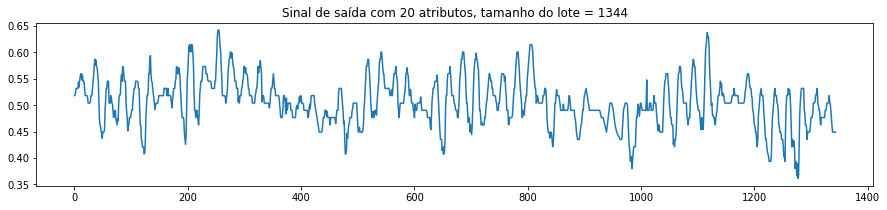

In [47]:
seq = y_batch[batch, :, signal]
plt.figure(figsize=(15,3))
plt.title(label='Sinal de saída com 20 atributos, tamanho do lote = 1344')
plt.plot(seq)
plt.show()

### Dados de validação

Uma rede neural pode treinar rapidamente várias epocas, no entanto existe um risco de "overfitting" sobre o modelo treinado e para que não haja uma generalização no treinamento o gerador de lote seleciona aleatoriamente uma sequência curta de dados e o utiliza durante o treinamento, porém para validação é necessário percorrer toda a sequência do conjunto de testes e medir a precisão da previsão para toda sequência de teste e treinamento. Por tanto, a variavel "validation_data" reune os dois vetores de entrada e saida para que possa validar os resultados.

In [48]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

## Rede Neural Recorrente


O conceito básico por trás de uma Rede Neural Recorrente (sigla para Recurrent Neural Network - RNN) é a sua Unidade Recorrente (UR), existem algumas variações de unidades recorrentes, como a LSTM (do inglês Long-Short-Term-Memory) e a Gated Recurrent Unit (GRU). Para este tutorial iremos utilizar a implementação da GRU  disponivel na biblioteca do Keras.

A ideia básica da GRU é que sua UR possui um valor interno que é atualizado sempre que a unidade recebe uma nova entrada, esse estado interno serve como uma memória que armazena os valores para o treinamento da rede usando um gradiente descendente. O novo valor do estado depente do valor antigo e de sua entrada atual.

Para treinar a UR, é necessário alterar gradualmente as matrizes de peso de cada entrada para que a UR produza a saída desejada para uma sequência de entrada, isso é feito automaticamente no TensorFlow.

In [49]:
# tensorflow e keras engine
model = Sequential()

Após o modelo podemos adicionar a RU para à rede, neste caso teram 512 saídas para cada intervalo de tempo da sequência, um fator importante é que essa será a primeira camada do modelo e o Keras precisa reconhecer o formato da entrada, ou seja, a entrada será um lote de sequências com um comprimento arbitrário onde cada observação possui 20 sinais de entrada (num_x_signals).

In [50]:
print('Numéro de sinais de entrada:',num_x_signals)

Numéro de sinais de entrada: 20


In [51]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


A GRU íra gerar um lote de sequências com 512 valores, e desejamos prever três saídas, portanto adicionamos mais uma camada densa que mapeia esses 512 valores para apenas 3 saídas, esses sinais foram limitados a estar entre 0 e 1 devido a função scaler, então também é necessário limitar a saída da rede para uma função de ativação sigmoid que limita o valor de saída entre 0 e 1.

In [52]:
model.add(Dense(num_y_signals, activation='sigmoid'))

O problema ao usar uma função de ativação Sigmoid é que a função irá mapear os valores de acordo com a função scaler e irá gerar valores entre -20 a 0 e +30 a 1 por exemplo, portanto, se limitarmos a saída da rede a 0 e 1 usando a função sigmoid os valores mapeados teram uma escala de variação de -20 e +30. Em vez disso podemos utilizar uma função de ativação linear para a saída, que permite que estes valores tenham uma saída arbitrária intependente dessa escala.

In [53]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Faixa de variação randomica para função linear.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

### Função Loss

Para a função de perda (Loss) será utilizado o Erro Quadrático Médio (do inglês Mean Squared Error sigla MSE) isso irá medir quanto a saída do modelo corresponde aos valores verdadeiros do sinal de saída. Porém, no início de uma sequência, o modelo só viu sinais de entrada por durante algumas etapas e sua saída gerada pode ser muito imprecisa e o uso do valor da perda nas etapas iniciais pode fazer com que o modelo distorça a saída anterior para resolver isso atribuímos ao modelo um "warmup-period" de 50 etapas no tempo em que não será utilizaada sua precisão na função de perda com objetivo de melhorar a precisão nas etapas anteriores.

In [54]:
# periodos para warmup-period
warmup_steps = 50

In [55]:
def loss_mse_warmup(y_true, y_pred):
    
    """
    Calcula MSE entre as saídas verdadeiras e saídas previsas
    porém ignora a sequência inicial de aquecimento.
    
    y_true é a saída desejada.
    y_pred é a saída do modelo.
    """

    # tamanho para os dois tensores de entrada:
    #  Ignora parte da sequecência "warmup", tomando como medida parte do tamanho dos tensores

    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # Calcula o MSE para cada valor de tensores
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    loss_mean = tf.reduce_mean(loss)

    return loss_mean

### Modelo de otimização

O RMSprop é um método para otimização com taxa adaptativa que usa uma média movel exponencial e será o modelo inicial para otimização.

In [56]:
optimizer = RMSprop(lr=1e-3)

Em seguida esse modelo será compilado pelo Keras e estara pronto a parte do treinamento.

In [57]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Este será um modelo relativamente pequeno com apenas duas camadas, e sua forma de saída será (None, None, 3) que significa que o modelo irá produzir um lote com um número de sequências onde cada uma corresponde a observação de 3 sinais que estão sendo previstos.

In [58]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         818688    
_________________________________________________________________
dense (Dense)                (None, None, 3)           1539      
Total params: 820,227
Trainable params: 820,227
Non-trainable params: 0
_________________________________________________________________


### Funções de Callback

Durante o treinamento é necessário salvar os checkpoints e os registros do processo para o TensorBoard criando funções de callback para o Keras, essa função irá escrever checkpoints durante o treinamento

In [59]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

Essa função irá parar quando os valores de otimização de desenpenho começarem a piorar durante a validação

In [60]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

Essa função irá escrever os logs do TensorBoard durante o treinamento

In [61]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=True,
                                   write_images=True)

Essa função reduz a taxa de aprendizado do otimizador caso a perda durante a validação não apresente uma melhora. A partir da taxa de aprendizado inicial de 1e-3, os valores serão multiplicados por 0,1.

In [62]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [63]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

### Treinamento da Rede Neural Recorrente

O próximo bloco de códigos irá treinar a rede neural, onde uma única época não corresponde a um único processamento mas sim a um lote gerado pela função que empacota e seleciona de forma aleatória uma sub-sequência do conjunto de treinamento.

Esse modelo foi treinado sobre um processador Intel Core i7

In [ ]:
%%time
model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

### Carregando os checkpoints

Devido o uso da função call back que faz uma parada antecipada no treinamento, é possível que o desempenho do modelo piore depois de várias épocas antes da interrupção do treinamento, ou sejá, é necessário carregar o último ponto de verificação salvo pois esse terá o melhor desempenho para os pesos de treinamento.

In [64]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

### Desempenho para o conjunto de teste

É possível avaliar o desempenho do modelo para os dados de teste.

In [65]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 19s 19s/sample - loss: 0.0022


In [66]:
print("loss (test-set):", result)

loss (test-set): 0.002181141171604395


In [67]:
# Caso hajam mais métricas é possível utiliza-las
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

In [69]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

%tensorboard --logdir 23_logs/

### Geração de previsões

A função a baixo auxlia na visualização dos sinais de saída previstos e compara-los com os valores verdadeiros
Esta função auxiliar traça os sinais de saída previstos e verdadeiros.

In [68]:
def output_frame(start_idx, length, train=True):
    """
    :param start_idx: Indice inicial da série temporal.
    :param length: Comprimento da sequência, número de elementos após o indice inicial.
    :param train: Valor Booleano para utilizar dados treinamento ou teste.
    """
    
    if train:
        # Usar dados de treinamento.
        x = x_train_scaled
        y_true = y_train
    else:
        # Usar dados de teste.
        x = x_test_scaled
        y_true = y_test
    
    # Indice final para sequência, tempo inicial mais comprimento.
    end_idx = start_idx + length
    
    #Selecione a seqüência do índice inicial especificado e comprimento.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Sinais de entrada para o modelo.
    x = np.expand_dims(x, axis=0)

    # Usar o modelo para prever os sinais de saída.
    y_pred = model.predict(x)
    
    # A saída do modelo tem valores entre 1 e 0.
    # Será necessário aplicar uma função de mapeamento inverso para deixar os dados rescalados
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    output = pd.DataFrame()
    output['Temperature'] = y_pred_rescaled[:,0]
    output['Wind'] = y_pred_rescaled[:,1]
    output['Presurre'] = y_pred_rescaled[:,2]
    output['Datetime'] = df['Odense']['Temp'][start_idx:start_idx+length].index.ravel()
    output = output.set_index('Datetime')
    
    # Visualização
    # Para cada sinal de saída.
    for signal in range(len(target_names)):
        # Pegar o sinal de saída previsto pelo modelo.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Pegar o sinal de saída do dataset original.
        signal_true = y_true[:, signal]

        # Configurações da figura.
        plt.figure(figsize=(15,5))

        # Visualização e labels.
        plt.plot(signal_true, label='Verdadeiro')
        plt.plot(signal_pred, label='Previsto')

        # Plotar periodo do warmup.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()
        
    return output

É importante ressaltar que os gráficos mostram apenas os sinais de saída, ou seja, apenas os valores selecionados como saída da rede e para isso é importante entender que existem incongruências em alguns casos, ou seja, a mudança de tempo entre os sinais de entrada e saída são mantidas fixas no gráfico e o modelo sempre irá prevê os sinais de saída de acordo com a variável shift_steps, que para este caso são 24 horas, o que não necessáriamente significa que o comprimento utilizado será o valor correto para previsão.

Outro ponto importante que vale ressaltar é que a previsão não será muito precisa para os primeiros 30 a 50 intervalos de tempo, isso porque o modelo viu poucos dados da entrada para este caso, por tanto quando o modelo é executado apenas por alguns intervalos de tempo ele conhece muito pouco o histórico dos sinais de entrada e isso gera uma imprecisão para as medições.

O modelo precisa da função "warmup" que é exibido como uma parte cinza no gráfico, isso significa que para o período de warmup as 50 etapas no cálculo do MSE os valores tem uma imprecisão maior.

### Saída
Após rodar o modelo é possível plotar os gráficos apenas entrando com os atributos para função "output_frame" onde start_idx é o indice de valores para onde se deseja iniciar o plot e length é o número de elementos, vale ressaltar que é possível plotar utilizando os dados de treinamento e os dados de teste, porém a diferença é que para os dados de teste o modelo não viu esses dados durante o treinamento.

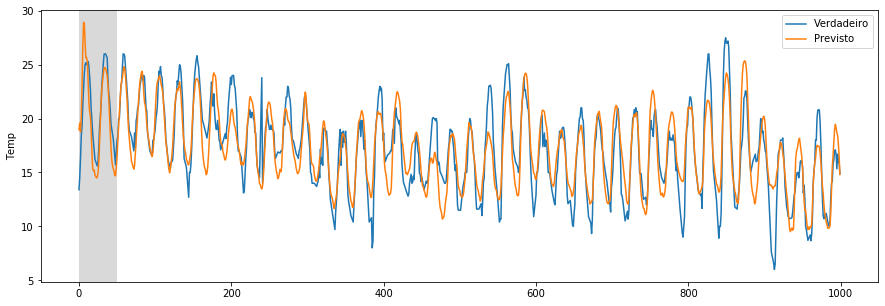

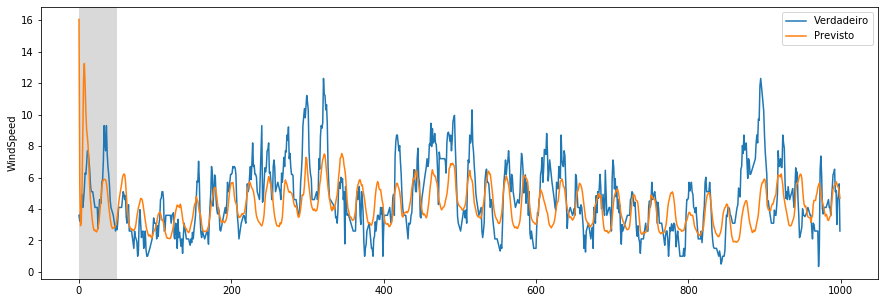

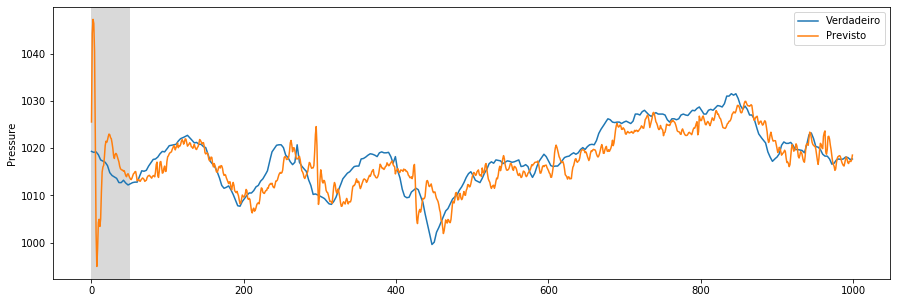

,Temperature,Wind,Presurre
Datetime,,,
1991-07-29 03:00:00,18.990046,16.053968,1025.530640
1991-07-29 04:00:00,19.597647,5.642962,1044.263794
1991-07-29 05:00:00,18.751139,2.939931,1047.236206
1991-07-29 06:00:00,20.188375,3.176970,1046.377319
1991-07-29 07:00:00,23.042465,5.308409,1040.467773
...,...,...,...
1991-09-08 14:00:00,18.687958,5.631419,1017.210449
1991-09-08 15:00:00,18.439621,5.420840,1017.236084
1991-09-08 16:00:00,17.647970,5.393754,1017.150085


In [70]:
# apenas com os dados de treinamento
output_frame(start_idx=100000, length=1000, train=True)

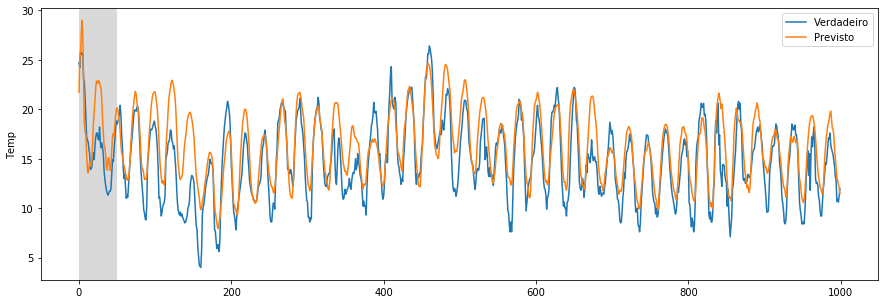

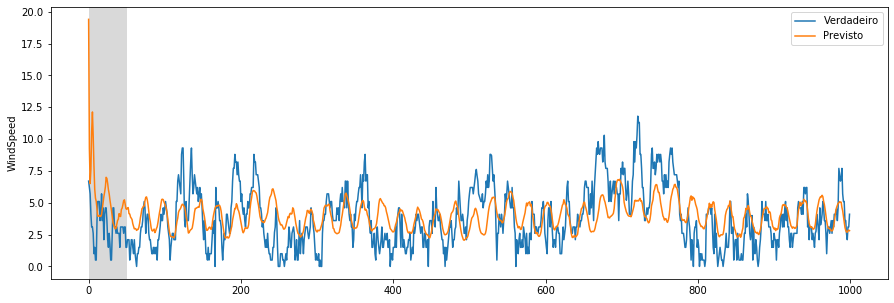

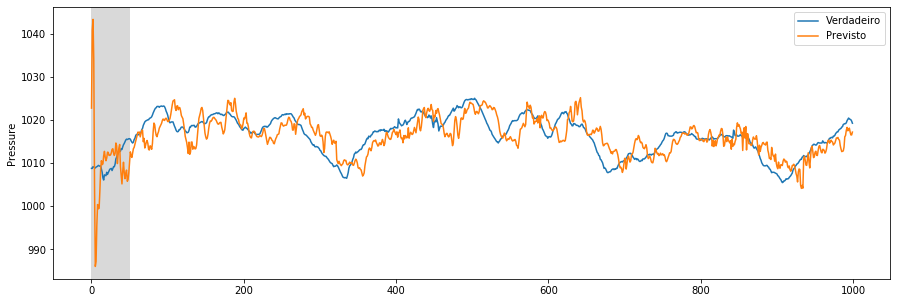

,Temperature,Wind,Presurre
Datetime,,,
1980-03-09 19:00:00,21.721680,19.400095,1022.810730
1980-03-09 20:00:00,25.034184,9.260886,1040.971558
1980-03-09 21:00:00,25.671854,6.507538,1043.434692
1980-03-09 22:00:00,27.565445,7.640202,1033.936279
1980-03-09 23:00:00,28.987782,10.625710,1004.580688
...,...,...,...
1980-04-20 06:00:00,13.102625,2.705796,1018.155884
1980-04-20 07:00:00,12.821672,2.696031,1017.283447
1980-04-20 08:00:00,12.474764,2.801788,1016.585449


In [71]:
## Apenas com os dados de teste
output_frame(start_idx=200, length=1000, train=False)

### Conclusão

Para este exemplo é possível notar que os dados de temperatura e pressão obtiveram valores bastante significativos quando comparados com os dados reais, já a velocidade do vento obteve resultados mais imprecisos devido principalmente a origem do sinal, por ser um sinal caótico os valores de previsão tornam-se mais complexos.
O ideal para este treinamento é remover os valores da série temporal de vento da entrada e saída da rede, também seria interessante alterar os valores das épocas e os hyperparametros da rede buscando uma melhor otimização do processo.

## Exemplo 02 - Aplicação de RNN para predição de série temporal de microestações na Amazônia

Neste exemplo, será utilizado das redes neurais recorrentes para imputação de dados climáticas da cidade de Monte Alegre no estado do Pará.

#### Dataset
Os dados das estações meteorológicas das cidades de Monte Alegre, Oriximina e Belterra a partir do ano 1988 à 2018

In [72]:
## Biblioteca
import datetime
from functools import reduce

### Preparação dos dados

In [73]:
## Leitura Dados
# Monte Alegre
mtal = pd.read_csv('dataset/dados_monte_alegre.csv', delimiter=';')
# Belterra
belt = pd.read_csv('dataset/dados_belterra.csv', delimiter=';')
# Oriximina
orix = pd.read_csv('dataset/dados_oriximina.csv', delimiter=';')

In [74]:
### Organização dataset
mtal[['day','month','year']] = mtal.Data.str.split('/', n = 3, expand = True)
mtal['day'] = pd.to_numeric(mtal.day)
mtal['month'] = pd.to_numeric(mtal.month)
mtal['year'] = pd.to_numeric(mtal.year)
mtal = mtal.replace([1200,1800],[12,18])

mtal['datetime'] = mtal[['day','month','year','Hora']].apply(lambda row:
                    datetime.datetime(year=row['year'], month=row['month'],day=row['day'],hour=row['Hora']),axis=1)
mtal = mtal.drop(columns=['Data','Hora','day','month','year','Unnamed: 10'])
mtal = mtal.set_index('datetime')
mtal.sort_values('datetime',ascending=True,inplace=True)
mtal = mtal['1988':'2018']

belt[['day','month','year']] = belt.Data.str.split('/', n = 3, expand = True)
belt['day'] = pd.to_numeric(belt.day)
belt['month'] = pd.to_numeric(belt.month)
belt['year'] = pd.to_numeric(belt.year)
belt = belt.replace([1200,1800],[12,18])

belt['datetime'] = belt[['day','month','year','Hora']].apply(lambda row:
                    datetime.datetime(year=row['year'], month=row['month'],day=row['day'],hour=row['Hora']),axis=1)
belt = belt.drop(columns=['Data','Hora','day','month','year','Unnamed: 10'])
belt = belt.set_index('datetime')
belt.sort_values('datetime',ascending=True,inplace=True)
belt = belt['1988':'2018']

orix[['day','month','year']] = orix.Data.str.split('/', n = 3, expand = True)
orix['day'] = pd.to_numeric(orix.day)
orix['month'] = pd.to_numeric(orix.month)
orix['year'] = pd.to_numeric(orix.year)
orix = orix.replace([1200,1800],[12,18])

orix['datetime'] = orix[['day','month','year','Hora']].apply(lambda row:
                    datetime.datetime(year=row['year'], month=row['month'],day=row['day'],hour=row['Hora']),axis=1)
orix = orix.drop(columns=['Data','Hora','day','month','year','Unnamed: 10'])
orix = orix.set_index('datetime')
orix.sort_values('datetime',ascending=True,inplace=True)
orix = orix['1988':'2018']

In [75]:
print('Tamanho do dataframe Monte Alegre: ',mtal.shape[0], ', Variáveis:',mtal.shape[1])
print('Tamanho do dataframe Belterra: ',belt.shape[0], ', Variáveis:',belt.shape[1])
print('Tamanho do dataframe Oriximina: ',orix.shape[0], ', Variáveis:',orix.shape[1])

Tamanho do dataframe Monte Alegre:  33731 , Variáveis: 8
Tamanho do dataframe Belterra:  33038 , Variáveis: 8
Tamanho do dataframe Oriximina:  30147 , Variáveis: 8


In [76]:
## Merge entre os datasets
dfs = [mtal,belt,orix]
dfs_final = reduce(lambda left,right: pd.merge(left,right, on='datetime'),dfs)

# Remover colunas
dfs_final = dfs_final.drop(columns=['Estacao_x','DirecaoVento_x','VelocidadeVento_x','Nebulosidade_x',
                                   'Estacao_y','DirecaoVento_y','VelocidadeVento_y','Nebulosidade_y',
                                   'Estacao','DirecaoVento','VelocidadeVento','Nebulosidade'])

dfs_final = dfs_final.rename(columns={'TempBulboSeco_x':'TempBS_MTA','TempBulboUmido_x':'TempBU_MTA','UmidadeRelativa_x':'UmidR_MTA','PressaoAtmEstacao_x':'Pres_MTA',
                                      'TempBulboSeco_y':'TempBS_BLT','TempBulboUmido_y':'TempBU_BLT','UmidadeRelativa_y':'UmidR_BLT','PressaoAtmEstacao_y':'Pres_BLT',
                                      'TempBulboSeco':'TempBS_ORX','TempBulboUmido':'TempBU_ORX','UmidadeRelativa':'UmidR_ORX','PressaoAtmEstacao':'Pres_ORX'} )
dfs_final.head()

,TempBS_MTA,TempBU_MTA,UmidR_MTA,Pres_MTA,TempBS_BLT,TempBU_BLT,UmidR_BLT,Pres_BLT,TempBS_ORX,TempBU_ORX,UmidR_ORX,Pres_ORX
datetime,,,,,,,,,,,,
1988-01-01 00:00:00,28.7,24.4,65.0,997.4,26.6,24.6,83.0,990.2,24.2,23.8,96.0,1003.8
1988-01-01 12:00:00,27.9,23.5,68.0,999.9,26.4,25.0,89.0,992.5,26.8,25.4,89.0,1004.1
1988-01-01 18:00:00,33.6,23.5,40.0,998.2,31.8,26.0,62.0,991.0,30.0,27.2,80.0,1002.7
1988-01-02 00:00:00,27.4,24.0,74.0,998.3,27.4,24.4,77.0,990.6,28.4,25.8,80.0,1002.6
1988-01-02 12:00:00,25.0,23.5,88.0,999.7,25.0,24.4,95.0,992.7,26.3,24.8,88.0,1006.2


### Visualização dos dados

Após organizar os dados será necessário visualizar para que se possa definir quais as variáveis mais importantes para a imputação.

Os dados foram plotados e divididos a partir de suas variáveis (Temperatura de Bulbo Seco; Temperatura de Bulbo Umido, Umidade e Pressão Atmosférica)

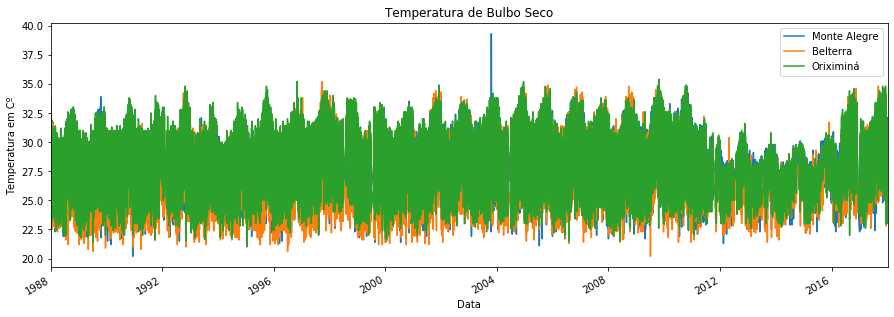

In [77]:
# Visualização do sensor Temperatura Bulbo Seco para as 3 estações
TempBulboS = dfs_final[['TempBS_MTA','TempBS_BLT','TempBS_ORX']].plot(figsize=(15,5),title='Temperatura de Bulbo Seco')
TempBulboS.legend(['Monte Alegre','Belterra','Oriximiná'])
plt.xlabel('Data')
plt.ylabel('Temperatura em Cº')
plt.show()

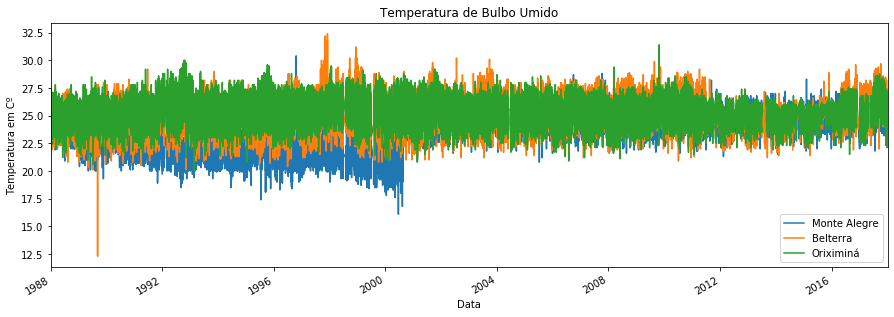

In [78]:
# Visualização do sensor Temperatura Bulbo Umido para as 3 estações
TempBulboU = dfs_final[['TempBU_MTA','TempBU_BLT','TempBU_ORX']].plot(figsize=(15,5),title='Temperatura de Bulbo Umido')
TempBulboU.legend(['Monte Alegre','Belterra','Oriximiná'])
plt.xlabel('Data')
plt.ylabel('Temperatura em Cº')
plt.show()

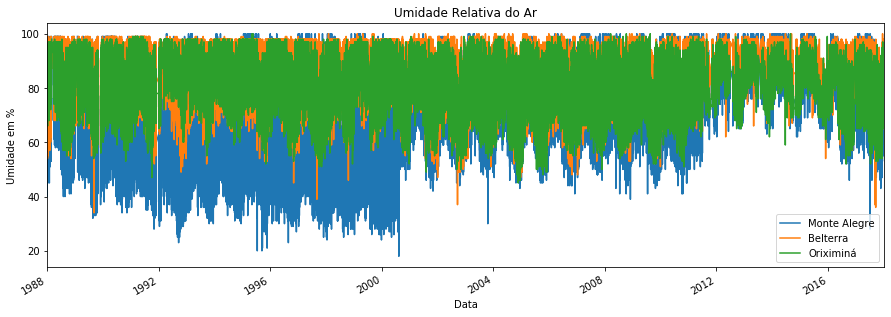

In [79]:
# Visualização do sensor Umidade para as 3 estações
Humid = dfs_final[['UmidR_MTA','UmidR_BLT','UmidR_ORX']].plot(figsize=(15,5),title='Umidade Relativa do Ar')
Humid.legend(['Monte Alegre','Belterra','Oriximiná'])
plt.xlabel('Data')
plt.ylabel('Umidade em %')
plt.show()

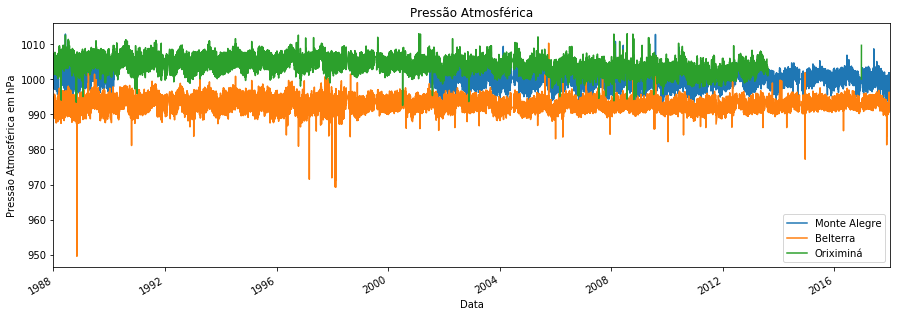

In [80]:
# Visualização do sensor Pressão Atmosférica para as 3 estações
PressaoP = dfs_final[['Pres_MTA','Pres_BLT','Pres_ORX']].plot(figsize=(15,5),title='Pressão Atmosférica')
PressaoP.legend(['Monte Alegre','Belterra','Oriximiná'])
plt.xlabel('Data')
plt.ylabel('Pressão Atmosférica em hPa')
plt.show()

### Correção de outliers

Algumas medições apresentam valores incongruentes com a média dos dados, e para isso será necessário aplicar um método que faça a correção desses dados discrepantes.

In [81]:
# Descrição do DataFrame
dfs_final.describe()

,TempBS_MTA,TempBU_MTA,UmidR_MTA,Pres_MTA,TempBS_BLT,TempBU_BLT,UmidR_BLT,Pres_BLT,TempBS_ORX,TempBU_ORX,UmidR_ORX,Pres_ORX
count,29921.000000,29821.000000,29643.000000,17608.000000,29864.000000,29704.000000,29561.000000,29905.000000,29924.000000,29774.000000,29621.000000,26592.000000
mean,27.569998,23.646397,71.928685,999.529208,26.712098,24.930127,86.552451,992.661766,27.720659,25.307594,82.005942,1003.821221
std,2.413840,1.602462,16.442361,1.891690,2.583035,1.371070,10.147083,1.866587,2.437576,1.226837,9.848434,2.156429
min,20.200000,16.100000,18.000000,992.500000,20.200000,12.300000,34.000000,949.600000,21.000000,20.000000,45.000000,983.300000
25%,25.800000,22.500000,61.000000,998.200000,24.800000,24.000000,81.000000,991.400000,26.000000,24.400000,76.000000,1002.400000
50%,27.300000,23.900000,74.000000,999.600000,26.200000,24.900000,90.000000,992.600000,27.400000,25.200000,84.000000,1003.700000
75%,29.300000,24.900000,85.000000,1000.900000,28.200000,25.800000,94.000000,993.900000,29.200000,26.200000,90.000000,1005.400000
max,39.300000,30.400000,100.000000,1012.800000,35.200000,32.400000,100.000000,1010.200000,35.400000,31.400000,100.000000,1012.900000


In [82]:
## Remoção de Outliers por quantil
low = .001
high = .9999
quant_df = dfs_final.quantile([low,high])

In [83]:
# Valores que representam os outliers
quant_df

,TempBS_MTA,TempBU_MTA,UmidR_MTA,Pres_MTA,TempBS_BLT,TempBU_BLT,UmidR_BLT,Pres_BLT,TempBS_ORX,TempBU_ORX,UmidR_ORX,Pres_ORX
0.0010,21.900,18.5820,26.0,993.7607,21.40000,21.00000,51.0,986.20000,22.00000,21.60000,50.0,997.6
0.9999,34.404,28.6018,100.0,1011.1786,34.80137,31.70297,100.0,1001.70096,34.90231,29.80454,100.0,1012.8


In [84]:
# Função para correção dos outliers
filt_df = dfs_final.apply(lambda x: x[(x>quant_df.loc[low,x.name]) & 
                                    (x < quant_df.loc[high,x.name])], axis=0)

filt_df.describe()

,TempBS_MTA,TempBU_MTA,UmidR_MTA,Pres_MTA,TempBS_BLT,TempBU_BLT,UmidR_BLT,Pres_BLT,TempBS_ORX,TempBU_ORX,UmidR_ORX,Pres_ORX
count,29874.000000,29788.000000,29401.000000,17588.000000,29815.000000,29659.000000,29487.000000,29869.000000,29887.000000,29739.000000,29579.000000,26559.000000
mean,27.577844,23.651427,71.790007,999.534234,26.719765,24.935564,86.577746,992.673889,27.726614,25.311436,82.038068,1003.828868
std,2.403255,1.592469,16.256774,1.876396,2.574708,1.359448,10.060455,1.800093,2.429756,1.219155,9.785707,2.133213
min,22.000000,18.600000,27.000000,993.800000,21.500000,21.100000,52.000000,986.300000,22.100000,21.700000,51.000000,997.700000
25%,25.800000,22.500000,61.000000,998.200000,24.900000,24.100000,81.000000,991.400000,26.000000,24.400000,76.000000,1002.400000
50%,27.300000,23.900000,74.000000,999.600000,26.200000,24.900000,90.000000,992.600000,27.400000,25.200000,84.000000,1003.700000
75%,29.300000,24.900000,84.000000,1000.900000,28.200000,25.800000,94.000000,993.900000,29.200000,26.200000,90.000000,1005.400000
max,34.400000,28.600000,99.000000,1010.700000,34.800000,31.700000,99.000000,1001.700000,34.900000,29.800000,99.000000,1012.600000


In [85]:
# Numerode elementos sem registro no DataFrame sem correção
dfs_final.isna().sum()

TempBS_MTA        8
TempBU_MTA      108
UmidR_MTA       286
Pres_MTA      12321
TempBS_BLT       65
TempBU_BLT      225
UmidR_BLT       368
Pres_BLT         24
TempBS_ORX        5
TempBU_ORX      155
UmidR_ORX       308
Pres_ORX       3337
dtype: int64

In [86]:
# Numerode elementos sem registro no DataFrame com correção
filt_df.isna().sum()

TempBS_MTA       55
TempBU_MTA      141
UmidR_MTA       528
Pres_MTA      12341
TempBS_BLT      114
TempBU_BLT      270
UmidR_BLT       442
Pres_BLT         60
TempBS_ORX       42
TempBU_ORX      190
UmidR_ORX       350
Pres_ORX       3370
dtype: int64

In [87]:
# Visualização dos outliers por boxplot dados sem correção
import seaborn as sns

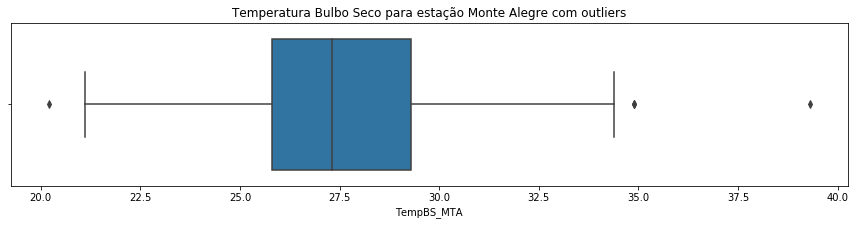

In [88]:
plt.figure(figsize=(15,3))
plt.title('Temperatura Bulbo Seco para estação Monte Alegre com outliers')
sns.boxplot(x=dfs_final['TempBS_MTA'])
plt.show()

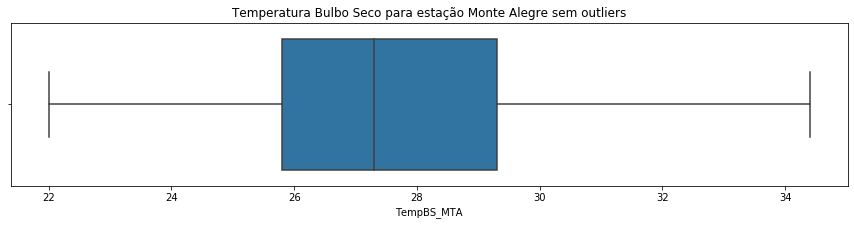

In [89]:
# Visualização dos outliers por boxplot dados com correção
plt.figure(figsize=(15,3))
plt.title('Temperatura Bulbo Seco para estação Monte Alegre sem outliers')
sns.boxplot(x=filt_df['TempBS_MTA'])
plt.show()

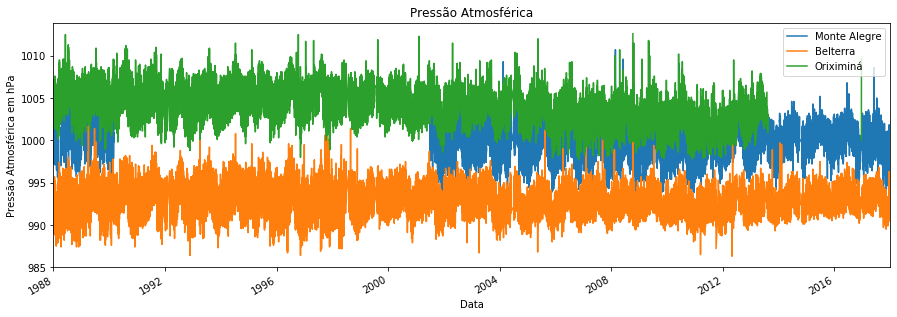

In [90]:
# Visualização do sensor Pressão Atmosférica para as 3 estações
PressaoP = filt_df[['Pres_MTA','Pres_BLT','Pres_ORX']].plot(figsize=(15,5),title='Pressão Atmosférica')
PressaoP.legend(['Monte Alegre','Belterra','Oriximiná'])
plt.xlabel('Data')
plt.ylabel('Pressão Atmosférica em hPa')
plt.show()

## Imputação de dados

Nota-se que no gráfico de Pressão atmosférica existe uma quantidade consideravel de valores nulos para cidade de Monte Alegre, ou seja, será necessário aplicar uma métrica inicial para preencher os dados sem registro, desta forma iremos aplicar uma imputação simples para os dados de Pressão Atmosférica na cidade de Monte Alegre, que consistem em usar os valores das cidades de Belterra e Oriximiná para estimar a os valores de Monte Alegre pela média entre as cidades Belterra e Oriximiná. Como a estação meteorológica de Monte Alegre fica a uma altitude entre as cidades de Oriximiná e e Belterra seu valor estimado por uma imputação simples não sofrera grandes impactos.

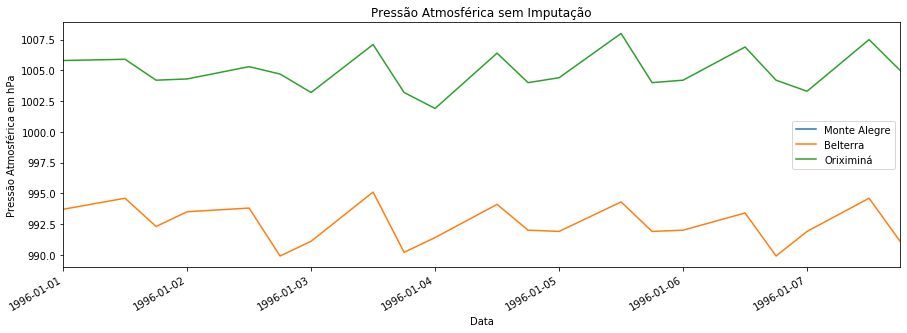

In [91]:
# Exemplo de visualização para imputação
# Exemplo entre os dias 01 e 07 de janeiro de 1996
preE = filt_df[['Pres_MTA','Pres_BLT','Pres_ORX']]['1996/01/01':'1996/01/07'].plot(figsize=(15,5),title='Pressão Atmosférica sem Imputação')
preE.legend(['Monte Alegre','Belterra','Oriximiná'])
plt.xlabel('Data')
plt.ylabel('Pressão Atmosférica em hPa')
plt.show()

In [92]:
# Media entre Belterra e Oriximina
filt_df['Pres_MTA'] = filt_df.Pres_MTA.fillna(filt_df[['Pres_BLT','Pres_ORX']].mean(axis=1))

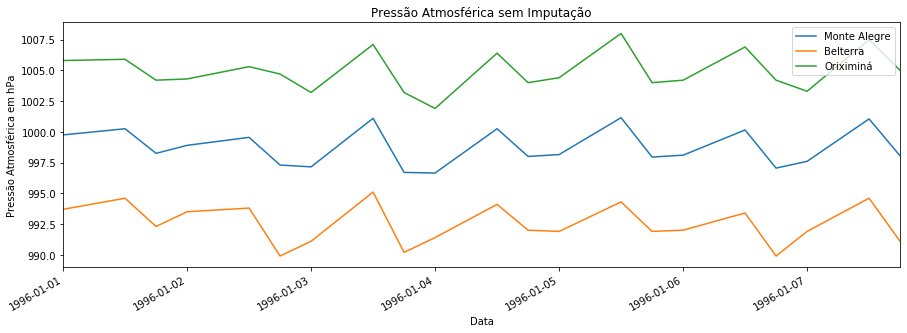

In [93]:
# Exemplo de visualização para imputação
# Exemplo entre os dias 01 e 07 de janeiro de 1996
preE = filt_df[['Pres_MTA','Pres_BLT','Pres_ORX']]['1996/01/01':'1996/01/07'].plot(figsize=(15,5),title='Pressão Atmosférica sem Imputação')
preE.legend(['Monte Alegre','Belterra','Oriximiná'])
plt.xlabel('Data')
plt.ylabel('Pressão Atmosférica em hPa')
plt.show()

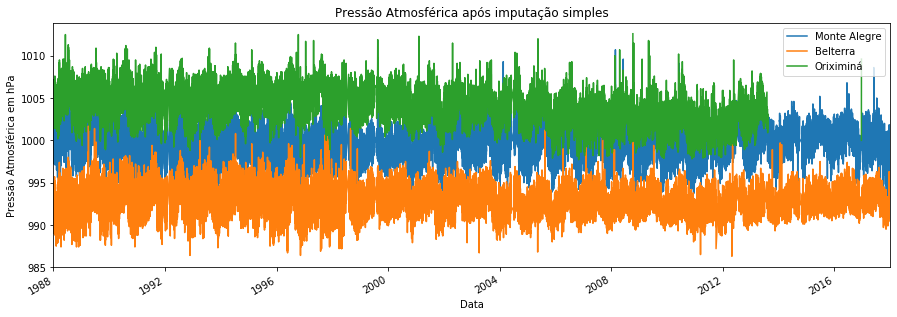

In [94]:
# Visualização do sensor Pressão Atmosférica para as 3 estações
PressaoP = filt_df[['Pres_MTA','Pres_BLT','Pres_ORX']].plot(figsize=(15,5),title='Pressão Atmosférica após imputação simples')
PressaoP.legend(['Monte Alegre','Belterra','Oriximiná'])
plt.xlabel('Data')
plt.ylabel('Pressão Atmosférica em hPa')
plt.show()

In [95]:
# Numerode elementos sem registro no DataFrame com correção
filt_df.isna().sum()

TempBS_MTA      55
TempBU_MTA     141
UmidR_MTA      528
Pres_MTA         0
TempBS_BLT     114
TempBU_BLT     270
UmidR_BLT      442
Pres_BLT        60
TempBS_ORX      42
TempBU_ORX     190
UmidR_ORX      350
Pres_ORX      3370
dtype: int64

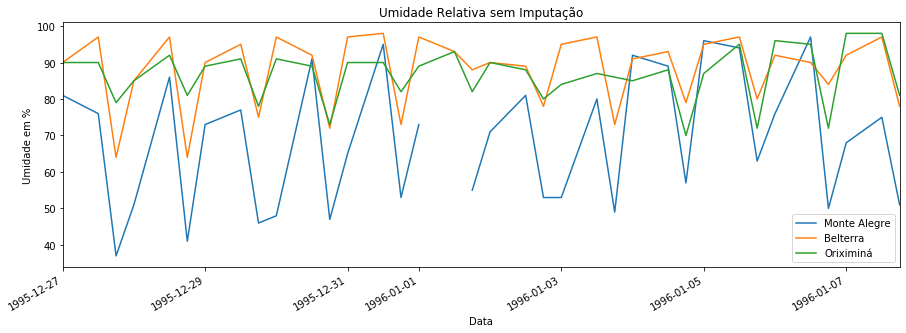

In [96]:
# Exemplo de visualização para imputação
# Exemplo entre os dias 01 e 07 de janeiro de 1996
humE = filt_df[['UmidR_MTA','UmidR_BLT','UmidR_ORX']]['1995/12/27':'1996/01/07'].plot(figsize=(15,5),title='Umidade Relativa sem Imputação')
humE.legend(['Monte Alegre','Belterra','Oriximiná'])
plt.xlabel('Data')
plt.ylabel('Umidade em %')
plt.show()

In [97]:
# Media entre Belterra e Oriximina
filt_df['UmidR_MTA'] = filt_df.UmidR_MTA.fillna(filt_df[['UmidR_BLT','UmidR_ORX']].mean(axis=1))

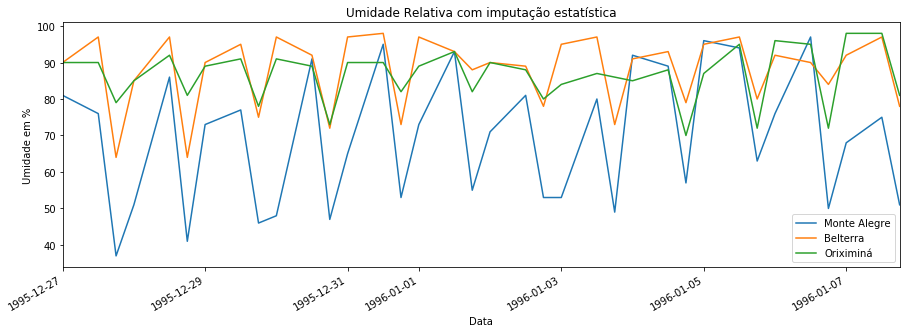

In [98]:
# Exemplo de visualização para imputação
# Exemplo entre os dias 01 e 07 de janeiro de 1996
humE = filt_df[['UmidR_MTA','UmidR_BLT','UmidR_ORX']]['1995/12/27':'1996/01/07'].plot(figsize=(15,5),title='Umidade Relativa com imputação estatística')
humE.legend(['Monte Alegre','Belterra','Oriximiná'])
plt.xlabel('Data')
plt.ylabel('Umidade em %')
plt.show()

In [99]:
# Numero de elementos sem registro no DataFrame Umidade Monte Alegre com correção
filt_df.UmidR_MTA.isna().sum()

180

### Imputação Multivariada

Devido a alta correlação entre os valores de temperatura é possível aplicar uma imputação multivariada entre os dados.

In [100]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [101]:
imp = IterativeImputer(max_iter=10, random_state=0)

## Imputação para Temperatura Bulbo Seco
timp = imp.fit(filt_df.loc[:,['TempBS_MTA','TempBS_BLT','TempBS_ORX']].to_numpy())
timp = timp.transform(filt_df.loc[:,['TempBS_MTA','TempBS_BLT','TempBS_ORX']].to_numpy())


## Imputação Para Temperatura Bulbo Umido
uimp = imp.fit(filt_df.loc[:,['TempBU_MTA','TempBS_BLT','TempBU_ORX']].to_numpy())
uimp = uimp.transform(filt_df.loc[:,['TempBU_MTA','TempBU_BLT','TempBU_ORX']].to_numpy())

In [102]:
df_final = filt_df.drop(['TempBS_MTA','TempBS_BLT','TempBS_ORX','TempBU_MTA','TempBU_BLT','TempBU_ORX'], axis=1)

In [103]:
df_final['TempBS_MTA'] = timp[:,0]
df_final['TempBS_BLT'] = timp[:,1]
df_final['TempBS_ORX'] = timp[:,2]
df_final['TempBU_MTA'] = uimp[:,0]
df_final['TempBU_BLT'] = uimp[:,1]
df_final['TempBU_ORX'] = uimp[:,2]

In [104]:
df_final.isna().sum()

UmidR_MTA      180
Pres_MTA         0
UmidR_BLT      442
Pres_BLT        60
UmidR_ORX      350
Pres_ORX      3370
TempBS_MTA       0
TempBS_BLT       0
TempBS_ORX       0
TempBU_MTA       0
TempBU_BLT       0
TempBU_ORX       0
dtype: int64

In [105]:
# Removendo os valores nulos
df_final = df_final.dropna()

In [219]:
df_final.tail()

,UmidR_MTA,Pres_MTA,UmidR_BLT,Pres_BLT,UmidR_ORX,Pres_ORX,TempBS_MTA,TempBS_BLT,TempBS_ORX,TempBU_MTA,TempBU_BLT,TempBU_ORX,Day,Hour
datetime,,,,,,,,,,,,,,
2013-08-12 00:00:00,78.0,998.6,95.0,992.1,83.0,1001.7,28.6,25.7,26.8,25.5,25.2,24.813255,224,0
2014-01-25 18:00:00,80.0,999.3,95.0,991.8,90.0,1007.2,27.3,25.1,25.0,24.6,24.7,24.653504,25,18
2016-05-06 18:00:00,73.0,999.2,76.0,992.6,78.0,997.8,29.9,30.1,30.0,26.0,27.0,26.800000,127,18
2016-12-19 00:00:00,98.0,1000.0,99.0,992.7,98.0,1000.0,23.9,24.0,23.9,23.6,23.8,24.364357,354,0
2016-12-20 00:00:00,97.0,998.9,95.0,992.0,92.0,1009.6,24.0,25.4,24.2,23.6,24.8,24.688494,355,0


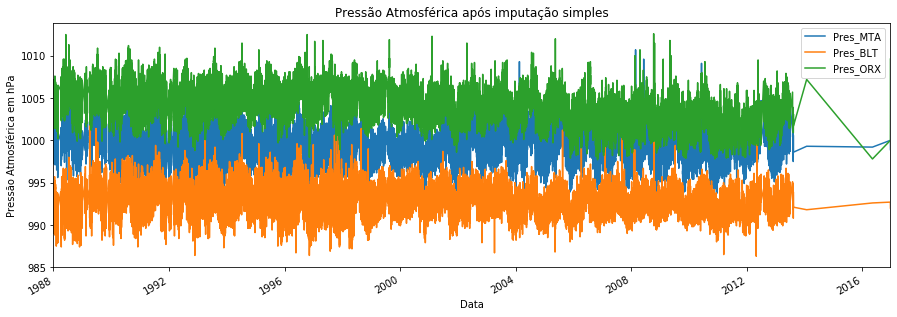

In [106]:
df_final[['Pres_MTA','Pres_BLT','Pres_ORX']].plot(figsize=(15,5),title='Pressão Atmosférica após imputação simples')
plt.xlabel('Data')
plt.ylabel('Pressão Atmosférica em hPa')
plt.show()

### Range dos Dados

Devido a variável "Pres_ORX" apresentar uma maior quantidade de dados faltantes (total 3370) para o ultimo periodo da série temporal, iremos considerar apenas os ultimos 25 anos de dados para nossa série final, ou seja, apenas dados dos anos **(1988 a 2013)** serão utilizados para o treinamento da rede. 

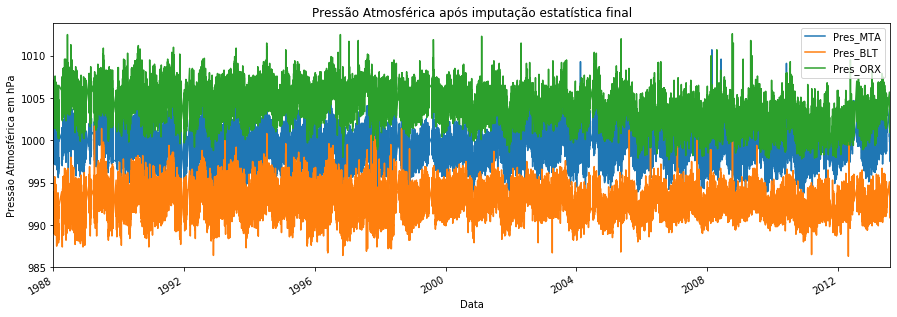

In [107]:
df_final[['Pres_MTA','Pres_BLT','Pres_ORX']]['1988':'2013'].plot(figsize=(15,5),title='Pressão Atmosférica após imputação estatística final')
plt.xlabel('Data')
plt.ylabel('Pressão Atmosférica em hPa')
plt.show()

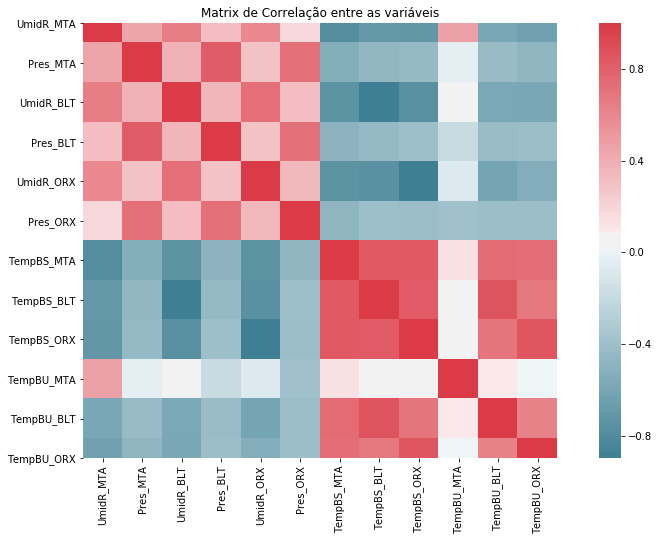

In [108]:
f, ax = plt.subplots(figsize=(15, 8))
plt.title('Matrix de Correlação entre as variáveis')
corr = df_final.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

## Rede Neural Recorrente

In [109]:
df = df_final

In [110]:
df.head()

,UmidR_MTA,Pres_MTA,UmidR_BLT,Pres_BLT,UmidR_ORX,Pres_ORX,TempBS_MTA,TempBS_BLT,TempBS_ORX,TempBU_MTA,TempBU_BLT,TempBU_ORX
datetime,,,,,,,,,,,,
1988-01-01 00:00:00,65.0,997.4,83.0,990.2,96.0,1003.8,28.7,26.6,24.2,24.4,24.6,23.8
1988-01-01 12:00:00,68.0,999.9,89.0,992.5,89.0,1004.1,27.9,26.4,26.8,23.5,25.0,25.4
1988-01-01 18:00:00,40.0,998.2,62.0,991.0,80.0,1002.7,33.6,31.8,30.0,23.5,26.0,27.2
1988-01-02 00:00:00,74.0,998.3,77.0,990.6,80.0,1002.6,27.4,27.4,28.4,24.0,24.4,25.8
1988-01-02 12:00:00,88.0,999.7,95.0,992.7,88.0,1006.2,25.0,25.0,26.3,23.5,24.4,24.8


In [111]:
print('Quantidade de registros: ', df.values.shape[0], ', Quantidade de atributos: ', df.values.shape[1])

Quantidade de registros:  25961 , Quantidade de atributos:  12


### Adicionando atributos aos dados

In [112]:
df['Day'] = df.index.dayofyear
df['Hour'] = df.index.hour

In [113]:
# Reorganizar dados
df = df_final[['Day','Hour','TempBS_MTA','TempBU_MTA','UmidR_MTA','Pres_MTA',
               'TempBS_BLT','TempBU_BLT','UmidR_BLT','Pres_BLT',
               'TempBS_ORX','TempBU_ORX','UmidR_ORX','Pres_ORX']]

In [114]:
df.head()

,Day,Hour,TempBS_MTA,TempBU_MTA,UmidR_MTA,Pres_MTA,TempBS_BLT,TempBU_BLT,UmidR_BLT,Pres_BLT,TempBS_ORX,TempBU_ORX,UmidR_ORX,Pres_ORX
datetime,,,,,,,,,,,,,,
1988-01-01 00:00:00,1,0,28.7,24.4,65.0,997.4,26.6,24.6,83.0,990.2,24.2,23.8,96.0,1003.8
1988-01-01 12:00:00,1,12,27.9,23.5,68.0,999.9,26.4,25.0,89.0,992.5,26.8,25.4,89.0,1004.1
1988-01-01 18:00:00,1,18,33.6,23.5,40.0,998.2,31.8,26.0,62.0,991.0,30.0,27.2,80.0,1002.7
1988-01-02 00:00:00,2,0,27.4,24.0,74.0,998.3,27.4,24.4,77.0,990.6,28.4,25.8,80.0,1002.6
1988-01-02 12:00:00,2,12,25.0,23.5,88.0,999.7,25.0,24.4,95.0,992.7,26.3,24.8,88.0,1006.2


### Selecionando Cidade Para Previsão

A cidade selecionada será a cidade de Oriximiná e as variáveis serão **(TempBS_MTA, TempBU_MTA, UmidR_MTA e Pres_MTA)**, sendo que a previsão busca por dados das próximas 24 horas acumuladas.

In [115]:
target_city = 'Oriximina'
target_names = ['TempBS_ORX','TempBU_ORX','UmidR_ORX','Pres_ORX']
shift_days = 3
shift_steps = shift_days * 3 # Número de horas

-  Novo DataFrame para o target

In [116]:
# Novo dataframe
df_targets = df[target_names].shift(-shift_days)
df_targets

,TempBS_ORX,TempBU_ORX,UmidR_ORX,Pres_ORX
datetime,,,,
1988-01-01 00:00:00,28.4,25.800000,80.0,1002.6
1988-01-01 12:00:00,26.3,24.800000,88.0,1006.2
1988-01-01 18:00:00,29.7,26.800000,79.0,1002.8
1988-01-02 00:00:00,28.2,26.600000,88.0,1002.6
1988-01-02 12:00:00,26.2,24.600000,88.0,1005.1
...,...,...,...,...
2013-08-12 00:00:00,23.9,24.364357,98.0,1000.0
2014-01-25 18:00:00,24.2,24.688494,92.0,1009.6
2016-05-06 18:00:00,NaN,NaN,NaN,NaN


### DataFrame para Vetor

Para entrada da rede é necessário converter o DataFrame (Pandas) para um vetor, isso é feito através da biblioteca NumPy, é necessário remover a ultima parte que contem valores NaN

#### Vetor de Entrada (X)

In [117]:
# Vetor de ENTRADA
x_data = df.values[0:-shift_steps]

print('Tipo dos dados: ',type(x_data))
print("Tamanho de entradas (observações) e número de atributos ", x_data.shape)

Tipo dos dados:  <class 'numpy.ndarray'>
Tamanho de entradas (observações) e número de atributos  (25952, 14)


#### Vetor de Saída (Y) Target

In [118]:
# Vetor de saída a partir do DataFrame target (Cidade Odense), ultimas linhas para previsão
y_data = df_targets.values[:-shift_steps]
print('Tipo dos dados: ',type(y_data))
print("Tamanho de saída (observações) e número de atributos ", y_data.shape)

Tipo dos dados:  <class 'numpy.ndarray'>
Tamanho de saída (observações) e número de atributos  (25952, 4)


In [119]:
print('Tamanho do Vetor de Entrada: ', len(x_data))
print('Tamanho do Vetor de Saída: ', len(y_data))

Tamanho do Vetor de Entrada:  25952
Tamanho do Vetor de Saída:  25952


#### Treinamento e Teste

Para este experimento serão selecionados 90% dos dados para treinamento e 10% para teste

In [120]:
# numero de dados de oberservação
num_data = len(x_data)

# fração para treinamento
train_split = 0.9

# número de elementos para treinamento
num_train = int(train_split * num_data)
print('Número de elementos para treinamento: ', num_train)
num_test = num_data - num_train
print('Número de elementos para teste: ', num_test)

Número de elementos para treinamento:  23356
Número de elementos para teste:  2596


#### Vetores de treinamento e teste:

In [121]:
# vetores de entrada para teste e treinamento
x_train = x_data[0:num_train]
x_test = x_data[num_train:]

In [122]:
# vetores de saída para teste e treinamento
y_train = y_data[0:num_train]
y_test = y_data[num_train:]

In [123]:
# numero de atributos de entrada
num_x_signals = x_data.shape[1]
print('Atributos de entrada: ', num_x_signals)
num_y_signals = y_data.shape[1]
print('Atributos de saída: ', num_y_signals)

Atributos de entrada:  14
Atributos de saída:  4


### Normalização dos dados

Os dados de entrada e saída estão em escalas diferentes, variando de valores negativos (ex: temperatura) a valores altos (pressão), por tanto, é necessário aplicar uma normalização dos dados para que esta variação seja de 0 à 1 pois as redes neurais trabalham melhor nesta escala, para isso é possível utilizar a função MinMaxScaler da biblioteca scikit-learn.

In [124]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: 0.0
Max: 1012.6


In [125]:
# objeto para os sinais de entrada
x_scaler = MinMaxScaler()

In [126]:
# função para normalização dos dados de entrada do treinamento
x_train_scaled = x_scaler.fit_transform(x_train)

In [127]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0000000000000002


In [224]:
x_test.shape

(2596, 14)

In [128]:
# o mesmo objeto x_caler é utilizado para os valores de teste
x_test_scaled = x_scaler.transform(x_test)

In [129]:
# outra funcao para normalização dos dados de treinamento e teste da saída
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [130]:
print("Min:", np.min(y_train_scaled))
print("Max:", np.max(y_train_scaled))

Min: 0.0
Max: 1.0


#### Geração de dados em lote
Os dados já estão preparados de forma vetorial e bi-dimensional, porém para o treinamento é possivel melhorar a forma de entrada para rede, organizando os mesmos em lotes, a função a baixo cria o melhor lote para sub-sequência dos dados de forma aleatória.

In [131]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

Quanto maior o tamanho do lote, maior a carga de trabalhos para os processadores, por tanto é necessário que o valor do batch_size seja de acordo com um valor ideial para o processodor e memória.

In [132]:
batch_size = 32

Usaremos um comprimento de sequência de 576, o que significa que cada sequência aleatória contém observações por 8 semanas. Um intervalo de tempo corresponde a uma hora, portanto, intervalos de tempo 24 x 3 correspondem a uma semana e 24 x 3 x 8 correspondem a 8 semanas.

In [133]:
sequence_length = 24 * 3 * 10

In [134]:
# gerador de dados em lote
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [135]:
# teste para o gerador de dados em lote
x_batch, y_batch = next(generator)

Isso nos fornece um lote aleatório de 32 seqüências, cada uma com 720 observações e cada observação com 14 sinais de entrada e 4 sinais de saída.

In [136]:
print(x_batch.shape)
print(y_batch.shape)

(32, 720, 14)
(32, 720, 4)


Podemos plotar esses dados para verificar como é o comportamento dos sinais e observar sua aleatoriedade

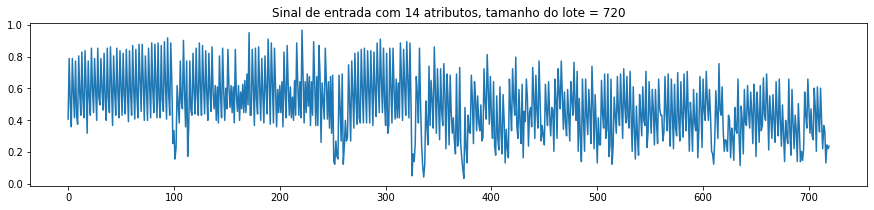

In [137]:
batch = 1   # Primeiro bloco 
signal = 2  #Sinal a partir dos dados com 14 atributos
seq = x_batch[batch, :, signal]
plt.figure(figsize=(15,3))
plt.title(label='Sinal de entrada com 14 atributos, tamanho do lote = 720')
plt.plot(seq)
plt.show()

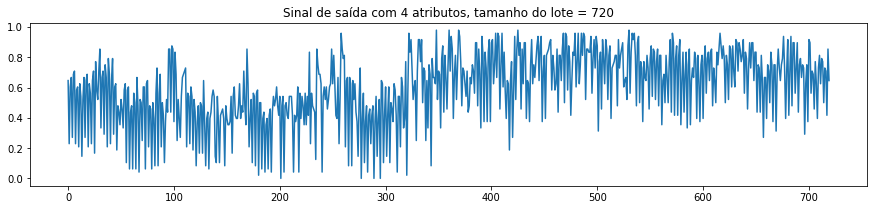

In [138]:
seq = y_batch[batch, :, signal]
plt.figure(figsize=(15,3))
plt.title(label='Sinal de saída com 4 atributos, tamanho do lote = 720')
plt.plot(seq)
plt.show()

### Dados de validação

Uma rede neural pode treinar rapidamente várias epocas, no entanto existe um risco de "overfitting" sobre o modelo treinado e para que não haja uma generalização no treinamento o gerador de lote seleciona aleatoriamente uma sequência curta de dados e o utiliza durante o treinamento, porém para validação é necessário percorrer toda a sequência do conjunto de testes e medir a precisão da previsão para toda sequência de teste e treinamento. Por tanto, a variavel "validation_data" reune os dois vetores de entrada e saida para que possa validar os resultados.

In [139]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [140]:
print('Formato dos dados de validação entrada: ', validation_data[0].shape )
print('Formato dos dados de validação saída: ', validation_data[1].shape )

Formato dos dados de validação entrada:  (1, 2596, 14)
Formato dos dados de validação saída:  (1, 2596, 4)


### Rede Neural Recorrente

O conceito básico por trás de uma Rede Neural Recorrente (sigla para Recurrent Neural Network - RNN) é a sua Unidade Recorrente (UR), existem algumas variações de unidades recorrentes, como a LSTM (do inglês Long-Short-Term-Memory) e a Gated Recurrent Unit (GRU). Para este tutorial iremos utilizar a implementação da GRU disponivel na biblioteca do Keras.

A ideia básica da GRU é que sua UR possui um valor interno que é atualizado sempre que a unidade recebe uma nova entrada, esse estado interno serve como uma memória que armazena os valores para o treinamento da rede usando um gradiente descendente. O novo valor do estado depente do valor antigo e de sua entrada atual.

Para treinar a UR, é necessário alterar gradualmente as matrizes de peso de cada entrada para que a UR produza a saída desejada para uma sequência de entrada, isso é feito automaticamente no TensorFlow.

In [141]:
# tensorflow e keras engine
model = Sequential()

Após o modelo podemos adicionar a RU para à rede, neste caso teram 512 saídas para cada intervalo de tempo da sequência, um fator importante é que essa será a primeira camada do modelo e o Keras precisa reconhecer o formato da entrada, ou seja, a entrada será um lote de sequências com um comprimento arbitrário onde cada observação possui 14 sinais de entrada (num_x_signals).

In [142]:
print('Numéro de sinais de entrada:',num_x_signals)

Numéro de sinais de entrada: 14


In [143]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

A GRU íra gerar um lote de sequências com 512 valores, e desejamos prever três saídas, portanto adicionamos mais uma camada densa que mapeia esses 512 valores para apenas 4 saídas, esses sinais foram limitados a estar entre 0 e 1 devido a função scaler, então também é necessário limitar a saída da rede para uma função de ativação sigmoid que limita o valor de saída entre 0 e 1.

In [144]:
model.add(Dense(num_y_signals, activation='sigmoid'))

O problema ao usar uma função de ativação Sigmoid é que a função irá mapear os valores de acordo com a função scaler e irá gerar valores entre -20 a 0 e +30 a 1 por exemplo, portanto, se limitarmos a saída da rede a 0 e 1 usando a função sigmoid os valores mapeados teram uma escala de variação de -20 e +30. Em vez disso podemos utilizar uma função de ativação linear para a saída, que permite que estes valores tenham uma saída arbitrária intependente dessa escala.

In [145]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Faixa de variação randomica para função linear.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

### Função de perda

Para a função de perda (Loss) será utilizado o Erro Quadrático Médio (do inglês Mean Squared Error sigla MSE) isso irá medir quanto a saída do modelo corresponde aos valores verdadeiros do sinal de saída. Porém, no início de uma sequência, o modelo só viu sinais de entrada por durante algumas etapas e sua saída gerada pode ser muito imprecisa e o uso do valor da perda nas etapas iniciais pode fazer com que o modelo distorça a saída anterior para resolver isso atribuímos ao modelo um "warmup-period" de 50 etapas no tempo em que não será utilizaada sua precisão na função de perda com objetivo de melhorar a precisão nas etapas anteriores.

In [146]:
# periodos para warmup-period
warmup_steps = 50

In [147]:
def loss_mse_warmup(y_true, y_pred):
    
    """
    Calcula MSE entre as saídas verdadeiras e saídas previsas
    porém ignora a sequência inicial de aquecimento.
    
    y_true é a saída desejada.
    y_pred é a saída do modelo.
    """

    # tamanho para os dois tensores de entrada:
    #  Ignora parte da sequecência "warmup", tomando como medida parte do tamanho dos tensores

    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # Calcula o MSE para cada valor de tensores
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    loss_mean = tf.reduce_mean(loss)

    return loss_mean

#### Modelo de otimização

O RMSprop é um método para otimização com taxa adaptativa que usa uma média movel exponencial e será o modelo inicial para otimização.

In [148]:
optimizer = RMSprop(lr=1e-3)

Em seguida esse modelo será compilado pelo Keras e estara pronto a parte do treinamento.

In [149]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

Este será um modelo relativamente pequeno com apenas duas camadas, e sua forma de saída será (None, None, 4) que significa que o modelo irá produzir um lote com um número de sequências onde cada uma corresponde a observação de 4 sinais que estão sendo previstos.

In [150]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 512)         809472    
_________________________________________________________________
dense_1 (Dense)              (None, None, 4)           2052      
Total params: 811,524
Trainable params: 811,524
Non-trainable params: 0
_________________________________________________________________


#### Funções de Callback

Durante o treinamento é necessário salvar os checkpoints e os registros do processo para o TensorBoard criando funções de callback para o Keras, essa função irá escrever checkpoints durante o treinamento

In [151]:
path_checkpoint = 'amazonia_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

Essa função irá parar quando os valores de otimização de desenpenho começarem a piorar durante a validação

In [152]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

Essa função irá escrever os logs do TensorBoard durante o treinamento

In [153]:
callback_tensorboard = TensorBoard(log_dir='./amazonia_logs/',
                                   histogram_freq=0,
                                   write_graph=True,
                                   write_images=True)

Essa função reduz a taxa de aprendizado do otimizador caso a perda durante a validação não apresente uma melhora. A partir da taxa de aprendizado inicial de 1e-3, os valores serão multiplicados por 0,1.

In [154]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [155]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

### Treinamento da Rede Neural Recorrente

Treinamento da Rede Neural Recorrente
O próximo bloco de códigos irá treinar a rede neural, onde uma única época não corresponde a um único processamento mas sim a um lote gerado pela função que empacota e seleciona de forma aleatória uma sub-sequência do conjunto de treinamento.

Esse modelo foi treinado sobre um processador Intel Core i7

In [ ]:
%%time
model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

In [156]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [161]:
%tensorboard --logdir amazoniza_logs/

In [167]:
## Resultados
train_log = pd.read_csv('run-train-tag-epoch_loss.csv', delimiter=',')
valid_log = pd.read_csv('run-validation-tag-epoch_loss.csv', delimiter=',')

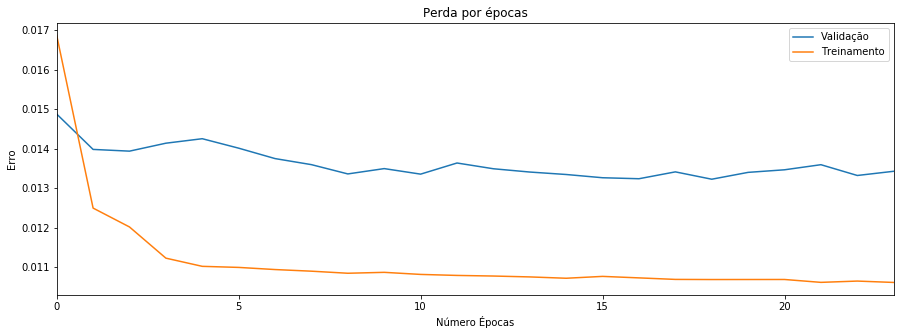

In [189]:
plt.figure(figsize=(15,5))
valid_log.set_index('Step')['Value'].plot(label='Validação')
train_log.set_index('Step')['Value'].plot(label='Treinamento')
plt.title(label='Perda por épocas')
plt.legend()
plt.xlabel('Número Épocas')
plt.ylabel('Erro')
plt.show()

### Carregando os checkpoints

Devido o uso da função call back que faz uma parada antecipada no treinamento, é possível que o desempenho do modelo piore depois de várias épocas antes da interrupção do treinamento, ou sejá, é necessário carregar o último ponto de verificação salvo pois esse terá o melhor desempenho para os pesos de treinamento.

In [190]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

#### Desempenho para o conjunto de teste

É possível avaliar o desempenho do modelo para os dados de teste

In [191]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 1s 1s/sample - loss: 0.0132


In [192]:
print("loss (test-set):", result)

loss (test-set): 0.013224692083895206


In [193]:
# Caso hajam mais métricas é possível utiliza-las
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

#### Geração de previsões

A função a baixo auxlia na visualização dos sinais de saída previstos e compara-los com os valores verdadeiros Esta função auxiliar traça os sinais de saída previstos e verdadeiros.

In [337]:
def output_frame(start_idx, length, train=True):
    """
    :param start_idx: Indice inicial da série temporal.
    :param length: Comprimento da sequência, número de elementos após o indice inicial.
    :param train: Valor Booleano para utilizar dados treinamento ou teste.
    """
    
    if train:
        # Usar dados de treinamento.
        x = x_train_scaled
        y_true = y_train
    else:
        # Usar dados de teste.
        x = x_test_scaled
        y_true = y_test
    
    # Indice final para sequência, tempo inicial mais comprimento.
    end_idx = start_idx + length
    
    #Selecione a seqüência do índice inicial especificado e comprimento.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Sinais de entrada para o modelo.
    x = np.expand_dims(x, axis=0)

    # Usar o modelo para prever os sinais de saída.
    y_pred = model.predict(x)
    
    # A saída do modelo tem valores entre 1 e 0.
    # Será necessário aplicar uma função de mapeamento inverso para deixar os dados rescalados
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    output = pd.DataFrame()
    output['Prev_TempBS_ORX'] = y_pred_rescaled[:,0]
    output['Prev_TempBU_ORX'] = y_pred_rescaled[:,1]
    output['Prev_UmidR_ORX'] = y_pred_rescaled[:,2]
    output['Prev_Pres_ORX'] = y_pred_rescaled[:,3]
    output['Datetime'] = df_targets.index[-start_idx:-start_idx+length]
    output = output.set_index('Datetime')
    
    
#     # Visualização
#     # Para cada sinal de saída.
#     for signal in range(len(target_names)):
#         # Pegar o sinal de saída previsto pelo modelo.
#         signal_pred = y_pred_rescaled[:, signal]
        
#         # Pegar o sinal de saída do dataset original.
#         signal_true = y_true[:, signal]

#         # Configurações da figura.
#         plt.figure(figsize=(15,5))

#         # Visualização e labels.
#         plt.plot(signal_true, label='Verdadeiro')
#         plt.plot(signal_pred, label='Previsto')

#         # Plotar periodo do warmup.
#         p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
#         # Plot labels etc.
#         plt.ylabel(target_names[signal])
#         plt.legend()
#         plt.savefig('output/model512_units_'+str(signal)+'.png')
#         plt.show()
        
    return output

In [338]:
df_targets.head()

,TempBS_ORX,TempBU_ORX,UmidR_ORX,Pres_ORX
datetime,,,,
1988-01-01 00:00:00,28.4,25.8,80.0,1002.6
1988-01-01 12:00:00,26.3,24.8,88.0,1006.2
1988-01-01 18:00:00,29.7,26.8,79.0,1002.8
1988-01-02 00:00:00,28.2,26.6,88.0,1002.6
1988-01-02 12:00:00,26.2,24.6,88.0,1005.1


In [358]:
length = 7
start_idx = 2096

In [359]:
# apenas com os dados de treinamento
saida = output_frame(start_idx=start_idx, length=length, train=False)

In [360]:
saida.head()

,Prev_TempBS_ORX,Prev_TempBU_ORX,Prev_UmidR_ORX,Prev_Pres_ORX
Datetime,,,,
2010-10-27 12:00:00,29.119671,26.276316,77.018417,1005.876160
2010-10-27 18:00:00,26.879826,25.426956,86.329887,1005.350098
2010-10-28 00:00:00,26.898533,25.020807,84.168022,1006.161743
2010-10-28 12:00:00,27.361355,25.428968,83.712509,1004.324036
2010-10-28 18:00:00,27.529064,25.189699,81.412727,1005.476135


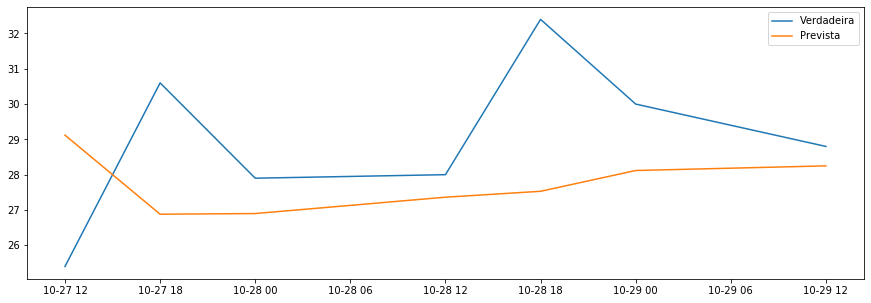

In [361]:
plt.figure(figsize=(15,5))
plt.plot(df_targets['TempBS_ORX'][-start_idx:-start_idx+length], label='Verdadeira')
plt.plot(saida['Prev_TempBS_ORX'], label='Prevista')
plt.legend()

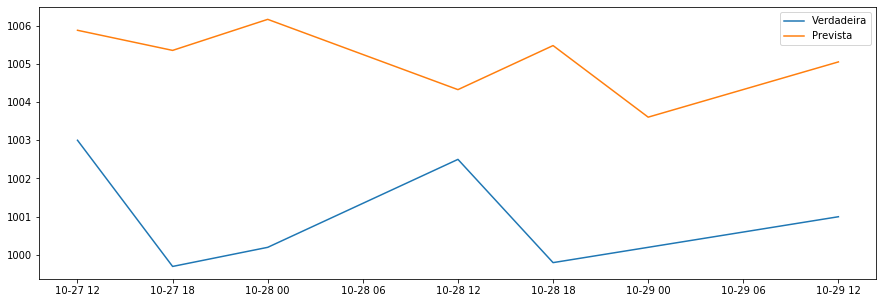

In [362]:
plt.figure(figsize=(15,5))
plt.plot(df_targets['Pres_ORX'][-start_idx:-start_idx+length], label='Verdadeira')
plt.plot(saida['Prev_Pres_ORX'], label='Prevista')
plt.legend()